The starred (*) sections are what's needed to run the final model.

# Loading processed dataset *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import gzip
import pandas as pd
import numpy as np
from sklearn import preprocessing
from itertools import compress
import math
from imblearn.over_sampling import RandomOverSampler
import os
import joblib
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

In [ ]:
main_path = '/content/drive/MyDrive/NUS/Y4S1/DSA4266/DSA4266 chromoteers/' #reb's path

In [ ]:
train_path = main_path +'train.csv.gz'

with gzip.open(train_path, 'rb') as file_in:
  train_df = pd.read_csv(file_in)

In [ ]:
# with read count
train_df['nreads'] = train_df['reads'].apply(len)

In [ ]:
#print(train_df.columns)

# Handling nucleotides *

In [ ]:
def nucleotides_as_cat(df):
    cat_df = df.copy(deep=True)
    #split the nucleotides into the relevant positions (+1, 0 and -1)
    cat_df['nucleotides_position-1']= cat_df['nucleotides'].str.slice(stop=5)
    cat_df['nucleotides_position']= cat_df['nucleotides'].str.slice(start=1, stop=6)
    cat_df['nucleotides_position+1']= cat_df['nucleotides'].str.slice(start=2, stop=7)

    #as category for xg boost
    cat_df['nucleotides_position+1'] = cat_df['nucleotides_position+1'].astype("category")
    cat_df['nucleotides_position'] = cat_df['nucleotides_position'].astype("category")
    cat_df['nucleotides_position-1'] = cat_df['nucleotides_position-1'].astype("category")

    return cat_df

# Handling nucleotides with one hot encoding

def nucleotides_ohe(df):
    ohe_df = df.copy(deep=True)

    #section to split the nucleotides
    split_nucleotides_df = pd.DataFrame(df.nucleotides.apply(list).tolist()) #split the nucleotides column into 7, 1 for each character
    split_nucleotides_df = split_nucleotides_df.drop(split_nucleotides_df.columns[3:5], axis=1) #drop the middle A column and 5th column with C (DRACH)
    split_nucleotides_df.columns = ['nucleotides_1', 'nucleotides_2', 'nucleotides_3', 'nucleotides_6', 'nucleotides_7'] #rename the columns
    ohe_df = pd.concat([ohe_df, split_nucleotides_df], axis=1) #concat back to the results_df dataframe
    #categorical data
    categorical_cols = ['nucleotides_1', 'nucleotides_2', 'nucleotides_3', 'nucleotides_6', 'nucleotides_7']

    #import pandas as pd
    ohe_df = pd.get_dummies(ohe_df, columns = categorical_cols)

    # Define possible nucleotide cols
    nucleotide_columns = ['nucleotides_1_A', 'nucleotides_1_C',  'nucleotides_1_G',  'nucleotides_1_T',
                          'nucleotides_2_A',  'nucleotides_2_G',  'nucleotides_2_T',
                          'nucleotides_3_A',  'nucleotides_3_G',
                          'nucleotides_6_A',  'nucleotides_6_C',  'nucleotides_6_T',
                          'nucleotides_1_A',  'nucleotides_7_C',  'nucleotides_7_G',  'nucleotides_7_T']

    # Check for missing cols
    cols_not_in_ohe_df = list(filter(lambda x: x not in list(ohe_df), nucleotide_columns))
    if cols_not_in_ohe_df:
        for col in cols_not_in_ohe_df:
            # Adding an empty numerical column
            ohe_df[col] = pd.Series(dtype=float)
    #print(ohe_df)
    return ohe_df

In [ ]:
# Process by OHE
ohe_input_df = nucleotides_ohe(train_df)
# Process by as Cat
cat_input_df = nucleotides_as_cat(train_df)

# Split train test *


In [ ]:
# Split train & test only after doing all preprocessing for simplicity
def split_train_test(df):
    # For splitting of dataset into train and test
    label_encoder = preprocessing.LabelEncoder() #label encoded instead of one hot encoding because there's a lot of values and later we have to split by the transcript id unique values
    df['encoded_transcript_id'] = label_encoder.fit_transform(df['transcript_id'])

    unique_transcript_id = df['encoded_transcript_id'].unique().tolist() #create a list of the unique transcript id values
    a = np.zeros(len(unique_transcript_id), dtype=int) #create an array of 0s

    b = math.floor((max(df['encoded_transcript_id'].unique())+1) / 5) #get about 20% of the total number of values
    a[:b] = 1 #assign 20% of the 0 array to be 1s instead
    np.random.seed(4266)
    np.random.shuffle(a) #shuffle them (like shuffling the index)
    a = a.astype(bool)
    filtered_list = list(compress(unique_transcript_id, a))

    train = df[~df['encoded_transcript_id'].isin(filtered_list)] #train dataframe
    test = df[df['encoded_transcript_id'].isin(filtered_list)] #test dataframe
    return train, test

In [ ]:
def create_x_y_test_train(df, chosen_cols, oversample):
    # Filter train and test
    train, test = split_train_test(df)

    # Generic cols to drop from X train and X test
    drop_cols = ['label','nucleotides','gene_id','reads','transcript_id','transcript_position','encoded_transcript_id','nreads'] # Not features in model
    # Keeping list of transcript ids and positions to match to predictions
    transcript_ids = test[['transcript_id','transcript_position']]
    print(chosen_cols)
    #print(train)

    # Chosen columns by feature selection
    if chosen_cols:
        X_train = train[chosen_cols]
        X_test = test[chosen_cols]
        y_train = train['label']
        y_test = test['label']
    else:
        X_train = train.drop(columns=drop_cols)
        X_test = test.drop(columns=drop_cols)
        y_train = train['label']
        y_test = test['label']

    if oversample:
      # Oversampling
      oversample = RandomOverSampler(sampling_strategy='minority', random_state=4266)
      X_over, y_over = oversample.fit_resample(X_train, y_train)
      return X_over,X_test,y_over,y_test,transcript_ids
    return X_train,X_test,y_train,y_test,transcript_ids

# Models

## Logistic Regression (baseline)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
#Logistic Regression
def train_logistic_regression(X_train, X_test,y_train,y_test, main_path, model_name):
    model_path = main_path + model_name #eg. 'top_features_xgboost_model.pkl'
    if os.path.isfile(model_path):
        model = joblib.load(model_path)
    # If not trained before, process and save model
    else:
        model = LogisticRegression(random_state=4266)
        model.fit(X_train, y_train)

        # Save the Trained Model
        joblib.dump(model, model_path)

    # Predict Probabilities
    y_prob = model.predict_proba(X_test)

    # Evaluate the Model
    threshold = 0.5  # You can adjust the threshold as needed
    y_pred = (y_prob[:, 1] >= threshold).astype(int)
    print(f'{model_name} Results')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    # Calculate ROC-AUC
    roc_auc = auc(fpr, tpr)
    print(f'ROC-AUC: {roc_auc:.2f}')

    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    # Calculate precision-recall AUC
    pr_auc = auc(recall, precision)
    print(f'PR-AUC: {pr_auc:.2f}')

    # Print a classification report for more detailed metrics
    print(classification_report(y_test, y_pred))
    return [roc_auc, pr_auc, fpr, tpr, precision, recall]

## NN model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

In [ ]:
# Neural network with standardizing (spoiler: it does better :D slightly)

def train_standardized_nn(X_train,X_test,y_train,y_test, main_path, model_name, scalar_name):
    scaler_path = main_path + scalar_name #eg. "standardized_nn_scalar"
    if os.path.isfile(scaler_path):
        scaler = joblib.load(scaler_path)
        ohe_X_train_scaled = scaler.transform(X_train)
    # If not processed before, process and save scalar
    else:
        # Standardize the numerical features
        scaler = StandardScaler()
        ohe_X_train_scaled = scaler.fit_transform(X_train)

        # Save the scaler to a file
        joblib.dump(scaler, scaler_path)
        print(f'Scaler saved to {scaler_path}')

    ohe_X_test_scaled = scaler.transform(X_test)

    model_path = main_path + model_name  # eg.'standardized_nn_model.keras'
    if os.path.isfile(model_path):
        model = keras.models.load_model(model_path)
    # If not trained before, process and save scalar
    else:
        # Define your neural network model
        model = keras.Sequential([
            # Input layer
            keras.layers.Input(shape=(ohe_X_train_scaled.shape[1],)),

            # Hidden layers
            keras.layers.Dense(units=64, activation='relu'),
            keras.layers.Dense(units=32, activation='relu'),

            # Output layer
            keras.layers.Dense(units=1, activation='sigmoid')
        ])

        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(ohe_X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2) #cross validation

        # Save the model to a file
        model.save(model_path)
        print(f'Model saved to {model_path}')
    print(f'{model_name} Results')
    # Evaluate the loaded model on the test data
    test_loss, test_accuracy = model.evaluate(ohe_X_test_scaled, y_test)
    print(f'Test accuracy: {test_accuracy}')

    # Predict probabilities for the test data using the loaded model
    predicted_probabilities = model.predict(ohe_X_test_scaled)
    print("Predicted Probabilities for Class 1:")
    print(predicted_probabilities)

    predicted_probabilities_df = pd.DataFrame(predicted_probabilities, columns=['score'])

    threshold = 0.5
    predicted_labels = (predicted_probabilities > threshold).astype(int)
    print(f"Predicted Labels: {predicted_labels}")
    print(f"Number of observations predicted as 1: {sum(predicted_labels)}")
    print(f"Percentage predicted as 1: {sum(predicted_labels)/len(ohe_X_test_scaled)}")

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, predicted_labels)
    # Calculate ROC-AUC
    roc_auc = auc(fpr, tpr)
    print(f'ROC-AUC: {roc_auc:.2f}')

    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, predicted_labels)
    # Calculate precision-recall AUC
    pr_auc = auc(recall, precision)
    print(f'PR-AUC: {pr_auc:.2f}')

    print(classification_report(y_test, predicted_labels))

    return [roc_auc, pr_auc, fpr, tpr, precision, recall]

## XGBoost *


In [ ]:
import xgboost as xgb

In [ ]:
#  XG boost model
def train_xgboost(X_train, X_test,y_train,y_test, main_path, model_name):
    model_path = main_path + model_name #eg. 'top_features_xgboost_model.pkl'
    if os.path.isfile(model_path):
        model = joblib.load(model_path)
    # If not trained before, process and save model
    else:
        model = xgb.XGBClassifier(random_state=42, enable_categorical=True)
        model.fit(X_train, y_train)

        # Save the Trained Model
        joblib.dump(model, model_path)

    # Predict Probabilities
    y_prob = model.predict_proba(X_test)

    # Evaluate the Model
    threshold = 0.5  # You can adjust the threshold as needed
    y_pred = (y_prob[:, 1] >= threshold).astype(int)
    print(f'{model_name} Results')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    # Calculate ROC-AUC
    roc_auc = auc(fpr, tpr)
    print(f'ROC-AUC: {roc_auc:.2f}')

    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    # Calculate precision-recall AUC
    pr_auc = auc(recall, precision)
    print(f'PR-AUC: {pr_auc:.2f}')

    # Print a classification report for more detailed metrics
    print(classification_report(y_test, y_pred))
    return [roc_auc, pr_auc, fpr, tpr, precision, recall]

## All Models with and without Oversampling

### Calculating and saving model results

In [ ]:
all_df = pd.DataFrame(columns = ['model', 'ROC_AUC', 'PR_AUC','Ave_AUC'])
all_plot_df = pd.DataFrame(columns = ['model', 'FPR', 'TPR', 'Precision', 'Recall'])
row = 0

# All w oversampling
models = ['no_over','over']

for para in models:
  cols = [] #full
  if para == 'no_over':
    over = False
  elif para == 'over':
    over = True

  # Logistic
  X_train,X_test,y_train,y_test, transcript_ids = create_x_y_test_train(ohe_input_df, cols, over)
  model_name = para + '_full_logistic_model'
  results = train_logistic_regression(X_train,X_test,y_train,y_test, main_path, model_name + '.pkl')
  all_df.loc[row]=[model_name,results[0],results[1],np.mean(results[:2])]
  all_plot_df.loc[row]= [model_name]+results[2:]
  row+=1

  # NN
  X_train,X_test,y_train,y_test, transcript_ids = create_x_y_test_train(ohe_input_df, cols, over)
  model_name = para + '_full_standardized_nn_model'
  scalar_name = para + '_full_standardized_nn_scalar'
  results = train_standardized_nn(X_train, X_test,y_train,y_test, main_path, model_name+ '.keras', scalar_name)
  all_df.loc[row]=[model_name,results[0],results[1],np.mean(results[:2])]
  all_plot_df.loc[row]= [model_name]+results[2:]
  row+=1

  # XG Boost
  X_train,X_test,y_train,y_test, transcript_ids = create_x_y_test_train(cat_input_df, cols, over)
  model_name = para + '_full_xgboost_model'
  results = train_xgboost(X_train,X_test,y_train,y_test, main_path, model_name+ '.pkl')
  all_df.loc[row]=[model_name,results[0],results[1],np.mean(results[:2])]
  all_plot_df.loc[row]= [model_name]+results[2:]
  row+=1

all_df_path = main_path + 'all.csv.gz'
all_df.to_csv(all_df_path, index=False, compression='gzip')
#all_plot_df_path = main_path + 'all_plot.csv.gz'
#all_plot_df.to_csv(all_plot_df_path, index=False, compression='gzip')

[]
no_over_full_logistic_model.pkl Results
Accuracy: 0.96
ROC-AUC: 0.54
PR-AUC: 0.34
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     23275
           1       0.55      0.08      0.14      1105

    accuracy                           0.96     24380
   macro avg       0.75      0.54      0.56     24380
weighted avg       0.94      0.96      0.94     24380

[]
no_over_full_standardized_nn_model.keras Results
762/762 [==============================] - 2s 2ms/step - loss: 0.1158 - accuracy: 0.9598
Test accuracy: 0.9598441123962402
762/762 [==============================] - 1s 2ms/step
Predicted Probabilities for Class 1:
[[0.00083301]
 [0.02143149]
 [0.00032585]
 ...
 [0.01005381]
 [0.00322317]
 [0.1611026 ]]
Predicted Labels: [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
Number of observations predicted as 1: [536]
Percentage predicted as 1: [0.02198523]
ROC-AUC: 0.65
PR-AUC: 0.47
              precision    recall  f1-score   support

          

In [ ]:
all_df

,model,ROC_AUC,PR_AUC,Ave_AUC
0,no_over_full_logistic_model,0.539565,0.336069,0.437817
1,no_over_full_standardized_nn_model,0.645370,0.474416,0.559893
2,no_over_full_xgboost_model,0.654034,0.470021,0.562028
3,over_full_logistic_model,0.791050,0.476411,0.633731
4,over_full_standardized_nn_model,0.814603,0.507916,0.661260
5,over_full_xgboost_model,0.816833,0.530394,0.673613


In [ ]:
all_plot_df

,model,FPR,TPR,Precision,Recall
0,no_over_full_logistic_model,"[0.0, 0.00322234156820623, 1.0]","[0.0, 0.08235294117647059, 1.0]","[0.04532403609515997, 0.5481927710843374, 1.0]","[1.0, 0.08235294117647059, 0.0]"
1,no_over_full_standardized_nn_model,"[0.0, 0.008807733619763695, 1.0]","[0.0, 0.2995475113122172, 1.0]","[0.04532403609515997, 0.6175373134328358, 1.0]","[1.0, 0.2995475113122172, 0.0]"
2,no_over_full_xgboost_model,"[0.0, 0.010483351235230934, 1.0]","[0.0, 0.318552036199095, 1.0]","[0.04532403609515997, 0.5906040268456376, 1.0]","[1.0, 0.318552036199095, 0.0]"
3,over_full_logistic_model,"[0.0, 0.20885069817400645, 1.0]","[0.0, 0.7909502262443439, 1.0]","[0.04532403609515997, 0.15239755884917175, 1.0]","[1.0, 0.7909502262443439, 0.0]"
4,over_full_standardized_nn_model,"[0.0, 0.08210526315789474, 1.0]","[0.0, 0.7113122171945702, 1.0]","[0.04532403609515997, 0.2914349276974416, 1.0]","[1.0, 0.7113122171945702, 0.0]"
5,over_full_xgboost_model,"[0.0, 0.060451127819548874, 1.0]","[0.0, 0.6941176470588235, 1.0]","[0.04532403609515997, 0.3528058877644894, 1.0]","[1.0, 0.6941176470588235, 0.0]"


### Loading model results (for easy access)

In [ ]:
# For the model results
all_df_path = main_path + 'all.csv.gz'

with gzip.open(all_df_path, 'rb') as file_in:
  all_df = pd.read_csv(file_in)

In [ ]:
# For the AUC plots
#all_plot_df_path = main_path + 'all_plot.csv.gz'

#with gzip.open(all_plot_df_path, 'rb') as file_in:
#  all_plot_df = pd.read_csv(file_in)

### Visualisation of AUC

                                model                               FPR  \
5             over_full_xgboost_model  [0.0, 0.060451127819548874, 1.0]   
4     over_full_standardized_nn_model   [0.0, 0.08210526315789474, 1.0]   
3            over_full_logistic_model   [0.0, 0.20885069817400645, 1.0]   
2          no_over_full_xgboost_model  [0.0, 0.010483351235230934, 1.0]   
1  no_over_full_standardized_nn_model  [0.0, 0.008807733619763695, 1.0]   
0         no_over_full_logistic_model   [0.0, 0.00322234156820623, 1.0]   

                               TPR  \
5   [0.0, 0.6941176470588235, 1.0]   
4   [0.0, 0.7113122171945702, 1.0]   
3   [0.0, 0.7909502262443439, 1.0]   
2    [0.0, 0.318552036199095, 1.0]   
1   [0.0, 0.2995475113122172, 1.0]   
0  [0.0, 0.08235294117647059, 1.0]   

                                         Precision  \
5   [0.04532403609515997, 0.3528058877644894, 1.0]   
4   [0.04532403609515997, 0.2914349276974416, 1.0]   
3  [0.04532403609515997, 0.15239755884917175,

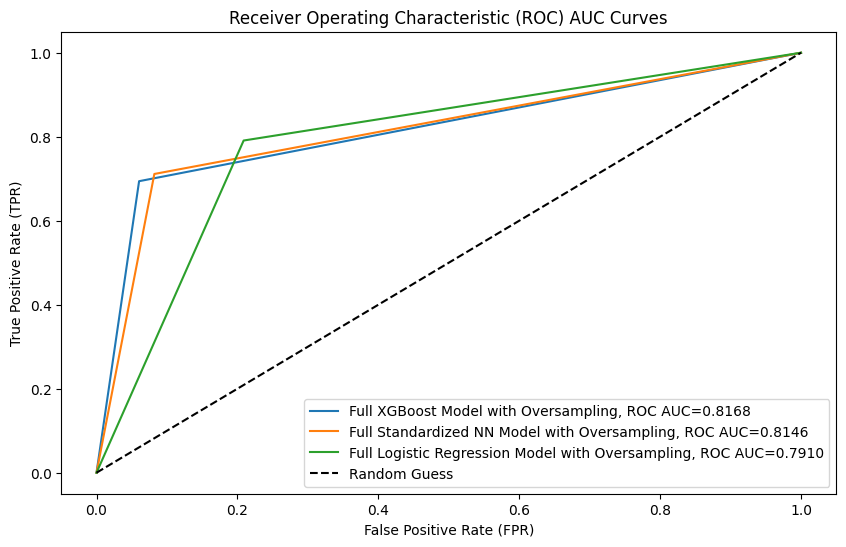

In [ ]:
# Plot ROC AUC curves
plt.figure(figsize=(10, 6))
all_plot_df['ROC'] = all_plot_df.apply(lambda row: auc(row['FPR'], row['TPR']), axis=1)

all_plot_df = all_plot_df.sort_values(by='ROC', ascending=False)
print(all_plot_df)
models = ['over_full_xgboost_model','over_full_logistic_model','over_full_standardized_nn_model']
labels = ['Full XGBoost Model with Oversampling','Full Standardized NN Model with Oversampling','Full Logistic Regression Model with Oversampling']
i = 0
for index, row in all_plot_df.iterrows():
  if i < 3:
    fpr = row['FPR']
    tpr = row['TPR']
    print(fpr)
    print(tpr)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label=f"{labels[i]}, ROC AUC={roc_auc:.4f}")
    i+=1

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Diagonal line for reference
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) AUC Curves')
plt.legend()

plt.show()

                                model                               FPR  \
5             over_full_xgboost_model  [0.0, 0.060451127819548874, 1.0]   
4     over_full_standardized_nn_model   [0.0, 0.08210526315789474, 1.0]   
3            over_full_logistic_model   [0.0, 0.20885069817400645, 1.0]   
1  no_over_full_standardized_nn_model  [0.0, 0.008807733619763695, 1.0]   
2          no_over_full_xgboost_model  [0.0, 0.010483351235230934, 1.0]   
0         no_over_full_logistic_model   [0.0, 0.00322234156820623, 1.0]   

                               TPR  \
5   [0.0, 0.6941176470588235, 1.0]   
4   [0.0, 0.7113122171945702, 1.0]   
3   [0.0, 0.7909502262443439, 1.0]   
1   [0.0, 0.2995475113122172, 1.0]   
2    [0.0, 0.318552036199095, 1.0]   
0  [0.0, 0.08235294117647059, 1.0]   

                                         Precision  \
5   [0.04532403609515997, 0.3528058877644894, 1.0]   
4   [0.04532403609515997, 0.2914349276974416, 1.0]   
3  [0.04532403609515997, 0.15239755884917175,

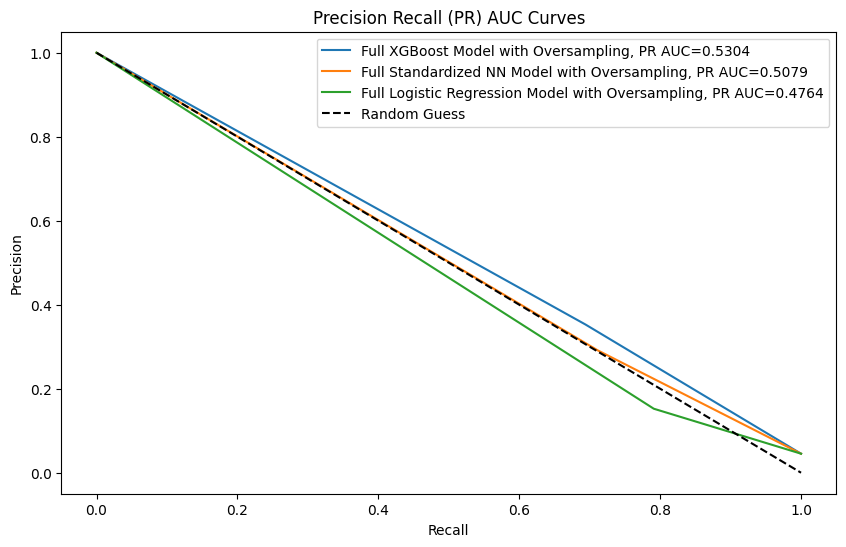

In [ ]:
# Plot PR AUC curves
plt.figure(figsize=(10, 6))
all_plot_df['PR'] = all_plot_df.apply(lambda row: auc(row['Recall'], row['Precision']), axis=1)

all_plot_df = all_plot_df.sort_values(by='PR', ascending=False)
print(all_plot_df)
#models = ['over_full_xgboost_model','over_full_logistic_model','over_full_standardized_nn_model']
labels = ['Full XGBoost Model with Oversampling','Full Standardized NN Model with Oversampling','Full Logistic Regression Model with Oversampling']
i = 0
for index, row in all_plot_df.iterrows():
  if i < 3:
    recall = row['Recall']
    precision = row['Precision']
    print(recall)
    print(precision)
    pr_auc = auc(recall,precision)
    plt.plot(recall,precision,label=f"{labels[i]}, PR AUC={pr_auc:.4f}")
    i+=1

plt.plot([0, 1], [1, 0], 'k--', label='Random Guess')  # Diagonal line for reference
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall (PR) AUC Curves')
plt.legend()

plt.show()

## Using selector threshold


### Getting the best features (used in the final model) *

In [ ]:
# Finding the threshold from the full data with oversampling
from sklearn.feature_selection import SelectFromModel
cols = []
X_train,X_test,y_train,y_test, transcript_ids = create_x_y_test_train(cat_input_df, cols, True)
selector = SelectFromModel(estimator=xgb.XGBClassifier(random_state=42, enable_categorical=True),importance_getter = 'feature_importances_').fit(X_train,y_train)
print(selector.threshold_)

[]
0.025641024


In [ ]:
# find the top features from the full model
features_df = pd.DataFrame(columns = ['model', 'ROC_AUC', 'PR_AUC','Ave_AUC','Threshold', 'Cols'])
features_plot_df = pd.DataFrame(columns = ['model', 'FPR', 'TPR', 'Precision', 'Recall'])
row = 0

model_name = 'over_full_xgboost_model'
loaded_model = joblib.load( main_path + model_name+ '.pkl')
result = pd.DataFrame()
result['columns']= X_train.columns
result['importances'] = loaded_model.feature_importances_
result.sort_values(by='importances',ascending=False,inplace=True)
print(result)

                     columns  importances
37      nucleotides_position     0.367250
16   combined_reads_p0_t2_v1     0.049484
20   combined_reads_p0_t3_v1     0.047112
23   combined_reads_p0_t3_v4     0.043842
35   combined_reads_p1_t3_v4     0.035630
32   combined_reads_p1_t3_v1     0.028000
17   combined_reads_p0_t2_v2     0.027838
38    nucleotides_position+1     0.027438
36    nucleotides_position-1     0.020578
11  combined_reads_p-1_t3_v4     0.016986
21   combined_reads_p0_t3_v2     0.015547
12   combined_reads_p0_t1_v1     0.015422
34   combined_reads_p1_t3_v3     0.014710
28   combined_reads_p1_t2_v1     0.014423
19   combined_reads_p0_t2_v4     0.014405
4   combined_reads_p-1_t2_v1     0.013772
5   combined_reads_p-1_t2_v2     0.013575
8   combined_reads_p-1_t3_v1     0.012973
33   combined_reads_p1_t3_v2     0.012621
31   combined_reads_p1_t2_v4     0.012555
14   combined_reads_p0_t1_v3     0.012319
24   combined_reads_p1_t1_v1     0.012306
29   combined_reads_p1_t2_v2     0

In [ ]:
result_filtered = result.loc[result['importances'] >= selector.threshold_] #select the rows that have importance > selector.threshold_
cols = list(result_filtered["columns"])
print(cols)

new_model_name = 'top_features_' + model_name
top_features_X_train,top_features_X_test,top_features_y_train,top_features_y_test,top_features_transcript_ids = create_x_y_test_train(cat_input_df, cols, True)
results = train_xgboost(top_features_X_train,top_features_X_test,top_features_y_train,top_features_y_test, main_path, new_model_name+ '.pkl')
features_df.loc[row]=[new_model_name,results[0],results[1],np.mean(results[:2]), selector.threshold_,cols]
features_plot_df.loc[row]= [new_model_name]+results[2:]

['nucleotides_position', 'combined_reads_p0_t2_v1', 'combined_reads_p0_t3_v1', 'combined_reads_p0_t3_v4', 'combined_reads_p1_t3_v4', 'combined_reads_p1_t3_v1', 'combined_reads_p0_t2_v2', 'nucleotides_position+1']
['nucleotides_position', 'combined_reads_p0_t2_v1', 'combined_reads_p0_t3_v1', 'combined_reads_p0_t3_v4', 'combined_reads_p1_t3_v4', 'combined_reads_p1_t3_v1', 'combined_reads_p0_t2_v2', 'nucleotides_position+1']
top_features_over_full_xgboost_model.pkl Results
Accuracy: 0.90
ROC-AUC: 0.82
PR-AUC: 0.50
              precision    recall  f1-score   support

           0       0.99      0.91      0.94     23275
           1       0.27      0.73      0.39      1105

    accuracy                           0.90     24380
   macro avg       0.63      0.82      0.67     24380
weighted avg       0.95      0.90      0.92     24380



In [ ]:
features_df

,model,ROC_AUC,PR_AUC,Ave_AUC,Threshold,Cols
0,top_features_over_full_xgboost_model,0.816473,0.504446,0.660459,0.025641,"[nucleotides_position, combined_reads_p0_t2_v1..."


### Visualisation of XGBoost feature importance

In [ ]:
result

,columns,importances
37,nucleotides_position,0.367250
16,combined_reads_p0_t2_v1,0.049484
20,combined_reads_p0_t3_v1,0.047112
23,combined_reads_p0_t3_v4,0.043842
35,combined_reads_p1_t3_v4,0.035630
32,combined_reads_p1_t3_v1,0.028000
17,combined_reads_p0_t2_v2,0.027838
38,nucleotides_position+1,0.027438
36,nucleotides_position-1,0.020578
11,combined_reads_p-1_t3_v4,0.016986


In [ ]:
# Define a mapping for replacement
importance_mapping = {
    'nucleotides_position': '5-mer at position 0',
    'nucleotides_position+1':'5-mer at the +1 flanking position',
    'combined_reads_p0_t2_v1' : 'mean of signal sd at position 0',
    'combined_reads_p0_t3_v1': 'mean of mean signal at position 0',
    'combined_reads_p0_t3_v4':'sd of mean signal at position 0',
    'combined_reads_p1_t3_v4':'sd of mean signal at the +1 flanking position',
    'combined_reads_p1_t3_v1': 'mean of mean signal at +1 flanking position',
    'combined_reads_p0_t2_v2' : 'minimum signal sd at position 0'
}


# Replace values in 'columns' based on the mapping
result['columns'] = result['columns'].replace(importance_mapping)

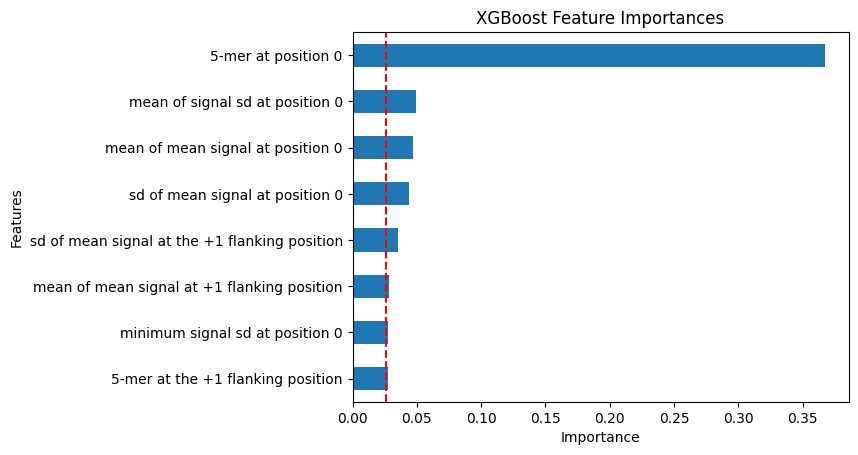

In [ ]:
# Create a horizontal bar plot
result = result.sort_values(by='importances', ascending=True).head(8)
result.plot(x='columns', y='importances', kind='barh', legend=False)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importances')
plt.axvline(x=selector.threshold_, color='red', linestyle='--', label='Selected Threshold')

plt.show()

## Visualising different thresholds

#### Calculating and saving results (only run once)

In [ ]:
#for full model
top_k_df = pd.DataFrame(columns = ['model', 'ROC_AUC', 'PR_AUC','Ave_AUC','Threshold', 'Cols','k'])
top_k_plot_df = pd.DataFrame(columns = ['model', 'FPR', 'TPR', 'Precision', 'Recall'])

row = 0
cols = [] # full
model_name = 'over_full_xgboost_model'
loaded_model = joblib.load( main_path + model_name+ '.pkl')
X_train,X_test,y_train,y_test, transcript_ids = create_x_y_test_train(cat_input_df, cols, True)
result = pd.DataFrame()
result['columns']= X_train.columns
result['importances'] = loaded_model.feature_importances_
result.sort_values(by='importances',ascending=False,inplace=True)
print(result)

k = 0
for thres in result['importances']:
  k += 1
  result_filtered = result.loc[result['importances'] >= thres] #select the rows that have importance > threshold
  cols = list(result_filtered["columns"])
  print(cols)

  new_model_name = 'top_' +str(k)+ '_' + model_name
  top_features_X_train,top_features_X_test,top_features_y_train,top_features_y_test,top_features_transcript_ids = create_x_y_test_train(cat_input_df, cols, True)
  results = train_xgboost(top_features_X_train,top_features_X_test,top_features_y_train,top_features_y_test, main_path, new_model_name+ '.pkl')
  top_k_df.loc[row]=[new_model_name,results[0],results[1],np.mean(results[:2]),thres,cols,k]
  top_k_plot_df.loc[row]= [new_model_name]+results[2:]
  row+=1
top_k_df_path = main_path + 'topk.csv.gz'
top_k_df.to_csv(top_k_df_path, index=False, compression='gzip')

[]
                     columns  importances
37      nucleotides_position     0.367250
16   combined_reads_p0_t2_v1     0.049484
20   combined_reads_p0_t3_v1     0.047112
23   combined_reads_p0_t3_v4     0.043842
35   combined_reads_p1_t3_v4     0.035630
32   combined_reads_p1_t3_v1     0.028000
17   combined_reads_p0_t2_v2     0.027838
38    nucleotides_position+1     0.027438
36    nucleotides_position-1     0.020578
11  combined_reads_p-1_t3_v4     0.016986
21   combined_reads_p0_t3_v2     0.015547
12   combined_reads_p0_t1_v1     0.015422
34   combined_reads_p1_t3_v3     0.014710
28   combined_reads_p1_t2_v1     0.014423
19   combined_reads_p0_t2_v4     0.014405
4   combined_reads_p-1_t2_v1     0.013772
5   combined_reads_p-1_t2_v2     0.013575
8   combined_reads_p-1_t3_v1     0.012973
33   combined_reads_p1_t3_v2     0.012621
31   combined_reads_p1_t2_v4     0.012555
14   combined_reads_p0_t1_v3     0.012319
24   combined_reads_p1_t1_v1     0.012306
29   combined_reads_p1_t2_v2   

#### Load top k features model results (for easy access)

In [ ]:
top_k_df_path = main_path + 'topk.csv.gz'

with gzip.open(top_k_df_path, 'rb') as file_in:
  top_k_df = pd.read_csv(file_in)

### Feature selection visualisation

In [ ]:
top_k_df.head()

,model,ROC_AUC,PR_AUC,Ave_AUC,Threshold,Cols,k
0,top_1_over_full_xgboost_model,0.738108,0.456672,0.597390,0.367250,['nucleotides_position'],1
1,top_2_over_full_xgboost_model,0.750978,0.441149,0.596063,0.049484,"['nucleotides_position', 'combined_reads_p0_t2...",2
2,top_3_over_full_xgboost_model,0.784033,0.458658,0.621345,0.047112,"['nucleotides_position', 'combined_reads_p0_t2...",3
3,top_4_over_full_xgboost_model,0.791227,0.466173,0.628700,0.043842,"['nucleotides_position', 'combined_reads_p0_t2...",4
4,top_5_over_full_xgboost_model,0.811055,0.491088,0.651072,0.035630,"['nucleotides_position', 'combined_reads_p0_t2...",5


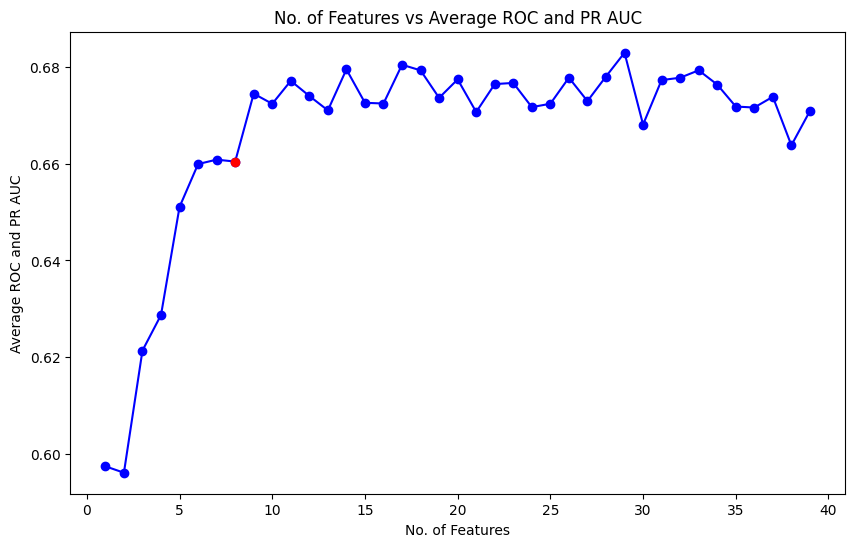

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot( top_k_df['k'],top_k_df['Ave_AUC'], marker = 'o', color='blue', zorder = 1) #label =''
plt.xlabel('No. of Features')
plt.ylabel('Average ROC and PR AUC')
plt.title('No. of Features vs Average ROC and PR AUC')
plt.legend().set_visible(False)
# Add a red dot at x=8, y=0.66 to show the selected model
plt.scatter(8, 0.660459, color='red', label='Red Dot', zorder = 2)
plt.show()

#Final model

## Training final model *

In [ ]:
#  XG boost model
def xgboost(X_train, y_train, main_path, model_name):
    model_path = main_path + model_name #eg. 'top_features_xgboost_model.pkl'

    if os.path.isfile(model_path):
        model = joblib.load(model_path)
    # If not trained before, process and save model
    else:
        model = xgb.XGBClassifier(random_state=42, enable_categorical=True) # removed tree_method="gpu_hist"
        model.fit(X_train, y_train)

        # Save the Trained Model
        joblib.dump(model, model_path)

    # Predict Probabilities
    y_prob = model.predict_proba(X_train)

    # Evaluate the Model
    threshold = 0.5  # You can adjust the threshold as needed
    y_pred = (y_prob[:, 1] >= threshold).astype(int)
    print(f'{model_name} Results')
    accuracy = accuracy_score(y_train, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_train, y_pred)
    # Calculate ROC-AUC
    roc_auc = auc(fpr, tpr)
    print(f'ROC-AUC: {roc_auc:.2f}')

    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred)
    # Calculate precision-recall AUC
    pr_auc = auc(recall, precision)
    print(f'PR-AUC: {pr_auc:.2f}')

    # Print a classification report for more detailed metrics
    print(classification_report(y_train, y_pred))
    #return [roc_auc, pr_auc, fpr, tpr, precision, recall]
    return y_prob

In [ ]:
def create_x_y_train(df, chosen_cols, oversample):
    # Filter train and test
    #train, test = split_train_test(df)

    # Generic cols to drop from X train and X test
    drop_cols = ['label','nucleotides','gene_id','reads','transcript_id','transcript_position','encoded_transcript_id','nreads'] # Not features in model
    # Keeping list of transcript ids and positions to match to predictions
    transcript_ids = df[['transcript_id','transcript_position']]
    transcript_ids['nreads'] = df['nreads'] #added for analysis
    print(chosen_cols)
    print(drop_cols)
    #print(train)

    # Chosen columns by feature selection
    if chosen_cols:
        X_train = df[chosen_cols]
        y_train = df['label']
    else:
        X_train = df.drop(columns=drop_cols)
        y_train = df['label']

    if oversample:
      # Oversampling
      oversample = RandomOverSampler(sampling_strategy='minority', random_state=4266)
      X_over, y_over = oversample.fit_resample(X_train, y_train)
      print(X_over, y_over)
      return X_over,y_over,transcript_ids

    return X_train, y_train, transcript_ids

In [ ]:
chosen = ['nucleotides_position',
'combined_reads_p0_t2_v1',
'combined_reads_p0_t3_v1',
'combined_reads_p0_t3_v4',
'combined_reads_p1_t3_v4',
'combined_reads_p1_t3_v1',
'combined_reads_p0_t2_v2',
'nucleotides_position+1'] #hardcoded

In [ ]:
chosen = features_df['Cols'][0]
final_model_name = 'xgboost'
X_train,y_train, transcript_ids = create_x_y_train(cat_input_df, chosen, True)
y_prob = xgboost(X_train,y_train, main_path, final_model_name+'.pkl')

['nucleotides_position', 'combined_reads_p0_t2_v1', 'combined_reads_p0_t3_v1', 'combined_reads_p0_t3_v4', 'combined_reads_p1_t3_v4', 'combined_reads_p1_t3_v1', 'combined_reads_p0_t2_v2', 'nucleotides_position+1']
['label', 'nucleotides', 'gene_id', 'reads', 'transcript_id', 'transcript_position', 'encoded_transcript_id', 'nreads']
       nucleotides_position  combined_reads_p0_t2_v1  combined_reads_p0_t3_v1  \
0                     AGACC                 7.382162               125.913514   
1                     AAACT                 3.226535               107.889535   
2                     AAACA                 3.642703                98.947027   
3                     GAACA                 2.899200                97.836500   
4                     GGACA                 5.870303               121.954545   
...                     ...                      ...                      ...   
232721                TGACT                 6.001892               119.054054   
232722             

## Visualisation of results on oversampled data

In [ ]:
X_train.head()

,nucleotides_position,combined_reads_p0_t2_v1,combined_reads_p0_t3_v1,combined_reads_p0_t3_v4,combined_reads_p1_t3_v4,combined_reads_p1_t3_v1,combined_reads_p0_t2_v2,nucleotides_position+1
0,AGACC,7.382162,125.913514,2.765244,2.522168,80.570270,1.040,GACCA
1,AAACT,3.226535,107.889535,3.526528,2.492530,94.290698,0.789,AACTG
2,AAACA,3.642703,98.947027,3.203816,1.484341,89.364324,1.020,AACAG
3,GAACA,2.899200,97.836500,1.928009,3.494937,89.154000,1.400,AACAT
4,GGACA,5.870303,121.954545,2.177236,2.379045,85.178788,2.680,GACAA


In [ ]:
y_pred_df = pd.DataFrame(y_prob, columns =['0','1'])
y_pred_df['actual'] = y_train
y_pred_df

,0,1,actual
0,0.995552,0.004448,0
1,0.830490,0.169510,0
2,0.979434,0.020566,0
3,0.722672,0.277328,0
4,0.999200,0.000800,0
...,...,...,...
232721,0.049244,0.950756,1
232722,0.230717,0.769283,1
232723,0.029756,0.970244,1
232724,0.042772,0.957228,1


In [ ]:
value_counts = y_pred_df['actual'].value_counts()

In [ ]:
value_counts

0    116363
1    116363
Name: actual, dtype: int64

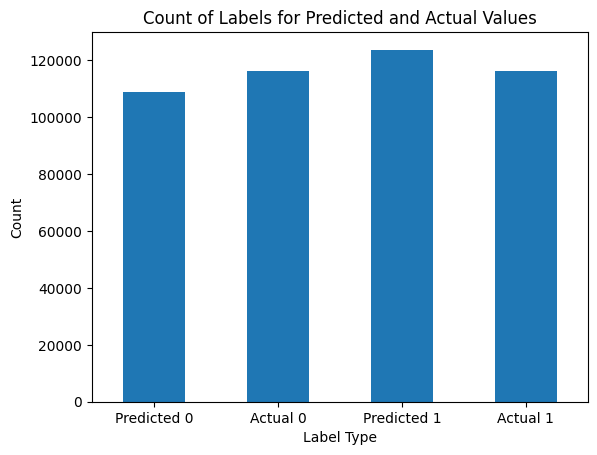

In [ ]:
df = pd.DataFrame({'y_true': y_train,
                   'y_pred': (y_pred_df['1'] >= 0.5).astype(int)})
#make a dataframe with the first column with the true labels and 2nd col is pred labels

df_bar = df.apply(pd.Series.value_counts)

index = ['Predicted 0', 'Actual 0', 'Predicted 1', 'Actual 1']
count = [df_bar['y_pred'].iloc[0], df_bar['y_true'].iloc[0], df_bar['y_pred'].iloc[1], df_bar['y_true'].iloc[1]]

df_plot = pd.DataFrame({'count': count, 'type':index})

df_plot.plot.bar(x="type", y="count", rot=0, title="Count of Labels for Predicted and Actual Values")
plt.xlabel('Label Type')
plt.ylabel('Count')
plt.legend().set_visible(False)

In [ ]:
df

,y_true,y_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
232721,1,1
232722,1,1
232723,1,1
232724,1,1


## Visualisation of the results on original data

In [ ]:
def xgboostpred(X_test,y_test, main_path, model_name):
    model_path = main_path + model_name + '.pkl'
    model = joblib.load(model_path)
    # Predict Probabilities
    y_prob = model.predict_proba(X_test)

    # Evaluate the Model
    threshold = 0.5  # You can adjust the threshold as needed
    y_pred = (y_prob[:, 1] >= threshold).astype(int)
    print(f'{model_name} Results')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    # Calculate ROC-AUC
    roc_auc = auc(fpr, tpr)
    print(f'ROC-AUC: {roc_auc:.2f}')

    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    # Calculate precision-recall AUC
    pr_auc = auc(recall, precision)
    print(f'PR-AUC: {pr_auc:.2f}')

    # Print a classification report for more detailed metrics
    print(classification_report(y_test, y_pred))
    #return [roc_auc, pr_auc, fpr, tpr, precision, recall]
    return y_prob

In [ ]:
chosen = features_df['Cols'][0]
final_model_name = 'xgboost'
X_test,y_test, transcript_ids = create_x_y_train(cat_input_df, chosen, False) # not oversampled
y_prob = xgboostpred(X_test,y_test, main_path, final_model_name)

<ipython-input-78-7a310527634f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcript_ids['nreads'] = df['nreads'] #added for analysis


['nucleotides_position', 'combined_reads_p0_t2_v1', 'combined_reads_p0_t3_v1', 'combined_reads_p0_t3_v4', 'combined_reads_p1_t3_v4', 'combined_reads_p1_t3_v1', 'combined_reads_p0_t2_v2', 'nucleotides_position+1']
['label', 'nucleotides', 'gene_id', 'reads', 'transcript_id', 'transcript_position', 'encoded_transcript_id', 'nreads']
xgboost Results
Accuracy: 0.91
ROC-AUC: 0.94
PR-AUC: 0.66
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    116363
           1       0.34      0.97      0.51      5475

    accuracy                           0.91    121838
   macro avg       0.67      0.94      0.73    121838
weighted avg       0.97      0.91      0.93    121838



In [ ]:
y_pred_df = pd.DataFrame(y_prob, columns =['0','1'])
y_pred_df['actual'] = y_test
y_pred_df

,0,1,actual
0,0.995552,0.004448,0
1,0.830490,0.169510,0
2,0.979434,0.020566,0
3,0.722672,0.277328,0
4,0.999200,0.000800,0
...,...,...,...
121833,0.010081,0.989919,1
121834,0.986273,0.013727,0
121835,0.034242,0.965758,1
121836,0.985963,0.014037,0


In [ ]:
value_counts = y_pred_df['actual'].value_counts()
value_counts

0    116363
1      5475
Name: actual, dtype: int64

In [ ]:
y_pred_df['pred'] = (y_pred_df['1'] >= 0.5).astype(int)

In [ ]:
value_counts = y_pred_df['pred'].value_counts()
value_counts

0    106249
1     15589
Name: pred, dtype: int64

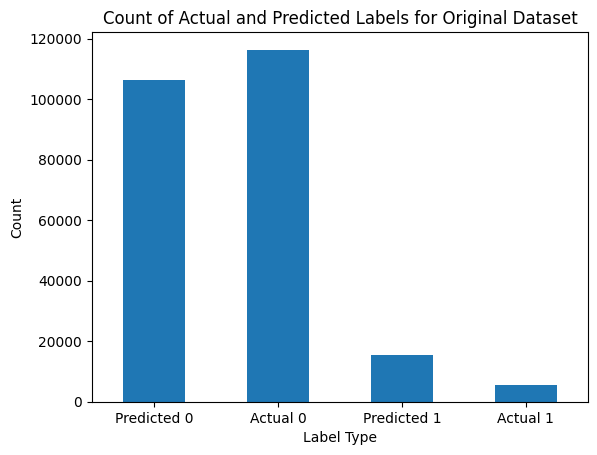

In [ ]:
df = pd.DataFrame({'y_true': y_test,
                   'y_pred': y_pred_df['pred']})
#make a dataframe with the first column with the true labels and 2nd col is pred labels

df_bar = df.apply(pd.Series.value_counts)

index = ['Predicted 0', 'Actual 0', 'Predicted 1', 'Actual 1']
count = [df_bar['y_pred'].iloc[0], df_bar['y_true'].iloc[0], df_bar['y_pred'].iloc[1], df_bar['y_true'].iloc[1]]

df_plot = pd.DataFrame({'count': count, 'type':index})

df_plot.plot.bar(x="type", y="count", rot=0, title="Count of Actual and Predicted Labels for Original Dataset")
plt.xlabel('Label Type')
plt.ylabel('Count')
plt.legend().set_visible(False)

In [ ]:
X_test.columns

Index(['nucleotides_position', 'combined_reads_p0_t2_v1',
       'combined_reads_p0_t3_v1', 'combined_reads_p0_t3_v4',
       'combined_reads_p1_t3_v4', 'combined_reads_p1_t3_v1',
       'combined_reads_p0_t2_v2', 'nucleotides_position+1'],
      dtype='object')

In [ ]:
transcript_ids.head()

,transcript_id,transcript_position,nreads
0,ENST00000000233,244,12101
1,ENST00000000233,261,11322
2,ENST00000000233,316,12075
3,ENST00000000233,332,12942
4,ENST00000000233,368,12872


In [ ]:
nread_df = pd.concat([transcript_ids, y_pred_df], axis=1)

### Visualisation of the results vs no. of reads

In [ ]:
nread_df['correct'] = (nread_df['actual'] == nread_df['pred'])
nread_df['wrong'] = (nread_df['actual'] != nread_df['pred'])

In [ ]:
nread_df.head()

,transcript_id,transcript_position,nreads,0,1,actual,pred,correct,wrong
0,ENST00000000233,244,12101,0.995552,0.004448,0,0,True,False
1,ENST00000000233,261,11322,0.830490,0.169510,0,0,True,False
2,ENST00000000233,316,12075,0.979434,0.020566,0,0,True,False
3,ENST00000000233,332,12942,0.722672,0.277328,0,0,True,False
4,ENST00000000233,368,12872,0.999200,0.000800,0,0,True,False


In [ ]:
count_df = nread_df.groupby(by=['nreads','correct']).count()

In [ ]:
grouped_df = count_df.reset_index()

In [ ]:
misclassified_reads = grouped_df[grouped_df['correct'] == False]
correct_reads = grouped_df[grouped_df['correct'] == True]

In [ ]:
misclassified_reads

,nreads,correct,transcript_id,transcript_position,0,1,actual,pred
20,1286,False,2,2,2,2,2,2
25,1290,False,2,2,2,2,2,2
28,1292,False,2,2,2,2,2,2
30,1293,False,1,1,1,1,1,1
32,1294,False,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
23329,62672,False,1,1,1,1,1,1
23350,62821,False,1,1,1,1,1,1
23394,63196,False,1,1,1,1,1,1
23425,63664,False,1,1,1,1,1,1


In [ ]:
wrong_df = pd.DataFrame({'nreads' : misclassified_reads['nreads'],
                         'nwrong' : misclassified_reads['transcript_id']})
correct_df = pd.DataFrame({'nreads' : correct_reads['nreads'],'ncorrect' : correct_reads['transcript_id']})
prop_df = pd.merge(wrong_df, correct_df ,on='nreads', how='outer')
prop_df = prop_df.fillna(0)

In [ ]:
prop_df

,nreads,nwrong,ncorrect
0,1286,2.0,16.0
1,1290,2.0,25.0
2,1292,2.0,25.0
3,1293,1.0,27.0
4,1294,1.0,33.0
...,...,...,...
19195,64137,0.0,1.0
19196,64178,0.0,1.0
19197,64201,0.0,1.0
19198,64333,0.0,1.0


In [ ]:
prop_df['prop'] = prop_df['nwrong']/(prop_df['nwrong']+prop_df['ncorrect'])

Text(0, 0.5, 'proportion misclassified')

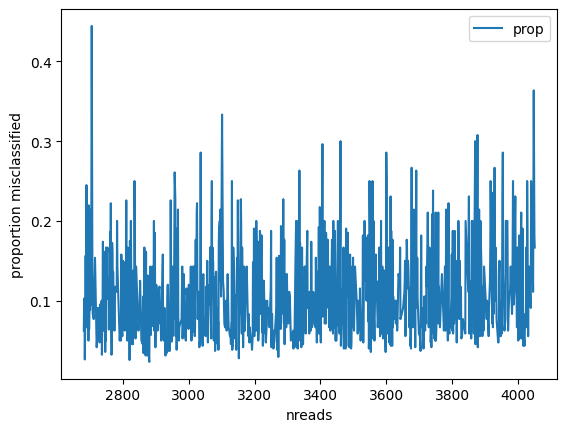

In [ ]:
prop_df[1000:2000].plot('nreads', 'prop', linestyle='-')
plt.ylabel('proportion misclassified')

Text(0, 0.5, 'proportion misclassified')

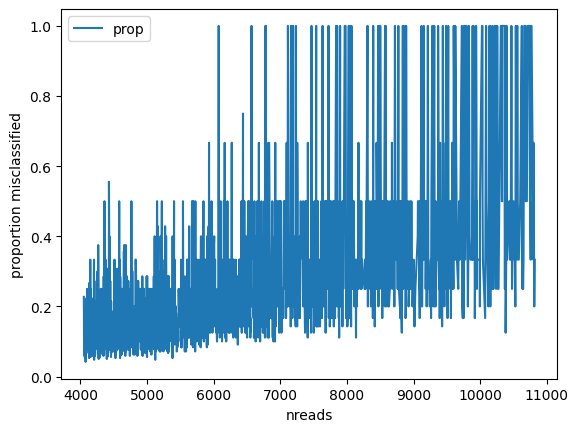

In [ ]:
prop_df[2000:4000].plot('nreads', 'prop', linestyle='-')
plt.ylabel('proportion misclassified')

Text(0, 0.5, 'proportion misclassified')

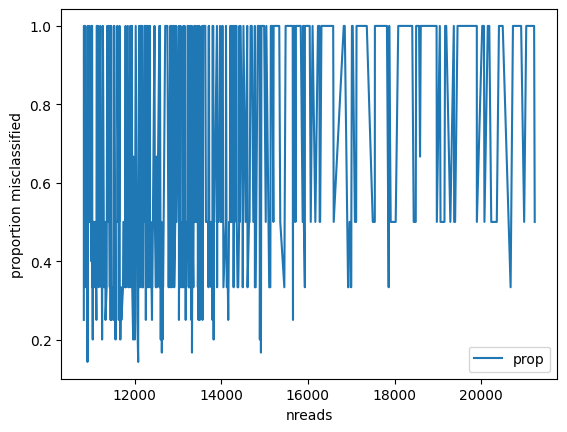

In [ ]:
prop_df[4000:4500].plot('nreads', 'prop', linestyle='-')
plt.ylabel('proportion misclassified')

Text(0, 0.5, 'proportion misclassified')

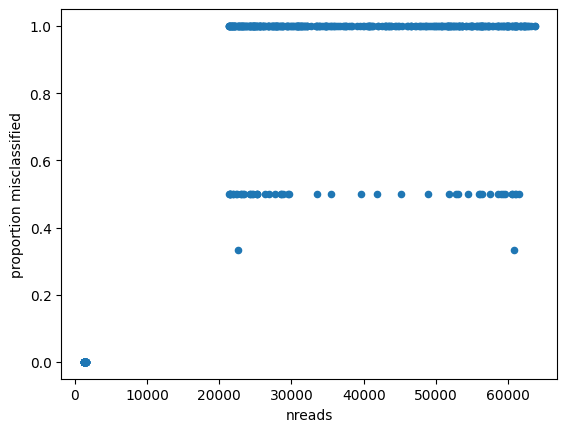

In [ ]:
prop_df[4500:5000].plot.scatter('nreads', 'prop')
plt.ylabel('proportion misclassified')

Text(0, 0.5, 'proportion misclassified')

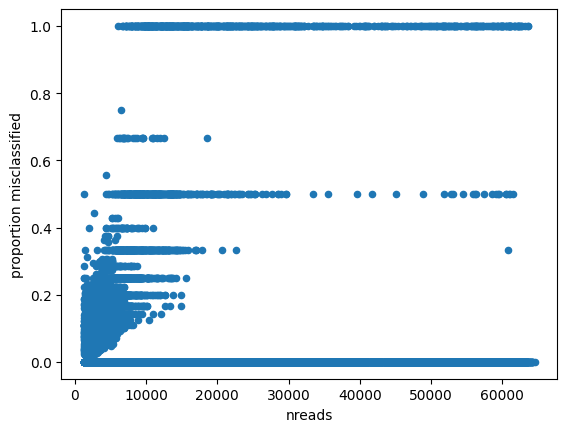

In [ ]:
#conclusion: tend to have more misclassifications with higher number of reads
# probably because there are fewer transcripts with that number of reads also so each mistake weighs more
prop_df.plot.scatter('nreads', 'prop')
plt.ylabel('proportion misclassified')

In [ ]:
highest_nread = nread_df[nread_df['nreads'] == 61539]

In [ ]:
highest_nread #highest read count with missclassification

,transcript_id,transcript_position,nreads,0,1,actual,pred,correct,wrong
26746,ENST00000274065,666,61539,0.997758,0.002242,0,0,True,False
49025,ENST00000331825,589,61539,0.416089,0.583911,0,1,False,True


In [ ]:
# no wrong prediction
prop_df[prop_df['nwrong']==0]

,nreads,nwrong,ncorrect,prop
4888,1260,0.0,1.0,0.0
4889,1266,0.0,2.0,0.0
4890,1267,0.0,1.0,0.0
4891,1269,0.0,3.0,0.0
4892,1270,0.0,2.0,0.0
...,...,...,...,...
19195,64137,0.0,1.0,0.0
19196,64178,0.0,1.0,0.0
19197,64201,0.0,1.0,0.0
19198,64333,0.0,1.0,0.0


### Visualisation of the distribution of mean signals

#### False negatives

In [ ]:
#finding the distribution of an incorrectly predicted transcript id & pos
pred_wrong = nread_df[nread_df['correct']==False]
# Predicted no modification when there is
FN_df = pred_wrong[pred_wrong['actual']==1]
FN_df

,transcript_id,transcript_position,nreads,0,1,actual,pred,correct,wrong
4989,ENST00000220913,575,2167,0.599616,0.400384,1,0,False,True
6105,ENST00000224073,247,7177,0.887948,0.112052,1,0,False,True
7187,ENST00000228506,1168,1964,0.535495,0.464505,1,0,False,True
9751,ENST00000241600,726,2722,0.567106,0.432894,1,0,False,True
9927,ENST00000242784,628,5583,0.750471,0.249529,1,0,False,True
...,...,...,...,...,...,...,...,...,...
113276,ENST00000581693,1591,1509,0.574110,0.425890,1,0,False,True
114031,ENST00000588734,1172,1699,0.528458,0.471542,1,0,False,True
115471,ENST00000602540,1160,7222,0.521930,0.478070,1,0,False,True
115819,ENST00000605895,861,3146,0.545153,0.454847,1,0,False,True


In [ ]:
FN_trans = train_df[(train_df['transcript_id'] == 'ENST00000220913')& (train_df['transcript_position'] == 575)]

In [ ]:
FN_trans.iloc[0]['reads']

'[[0.00863, 4.26, 97.8, 0.00449, 6.84, 119.0, 0.00797, 4.56, 79.7], [0.00594, 9.21, 103.0, 0.00332, 3.31, 127.0, 0.00564, 4.0, 77.6], [0.011, 3.48, 104.0, 0.00365, 9.29, 125.0, 0.00968, 1.96, 78.2], [0.0113, 4.1, 104.0, 0.00888, 9.11, 119.0, 0.00831, 2.24, 77.2], [0.0213, 5.15, 96.7, 0.00531, 2.04, 112.0, 0.00531, 4.33, 79.8], [0.00664, 3.97, 106.0, 0.00771, 9.17, 119.0, 0.0143, 2.09, 77.9], [0.0156, 4.53, 105.0, 0.0083, 11.3, 115.0, 0.0156, 1.87, 77.3], [0.0329, 3.96, 104.0, 0.0156, 10.4, 117.0, 0.00398, 0.705, 76.6], [0.00398, 2.09, 96.2, 0.0126, 5.21, 113.0, 0.00764, 3.38, 75.9], [0.0167, 4.49, 102.0, 0.014, 6.0, 113.0, 0.00832, 1.86, 78.5], [0.0175, 11.5, 95.3, 0.00631, 12.1, 117.0, 0.0073, 3.22, 78.8], [0.00896, 9.26, 104.0, 0.0073, 8.43, 117.0, 0.00531, 2.28, 79.4], [0.0076, 5.63, 97.3, 0.00531, 10.1, 122.0, 0.00465, 4.45, 79.2], [0.00432, 3.89, 106.0, 0.00398, 3.89, 125.0, 0.011, 3.18, 81.2], [0.0084, 3.73, 103.0, 0.00963, 10.6, 118.0, 0.00896, 3.85, 78.3], [0.00797, 3.39, 104.0

In [ ]:
import json
def get_means(input_reads):
    input_reads = json.loads(input_reads)
    #for var in range(9): #each var each position
    val_list = []
    for read in input_reads:
        val_list.append(read[5])
    return val_list

In [ ]:
data = get_means(FN_trans.iloc[0]['reads'])

In [ ]:
nunique = len(set(data))

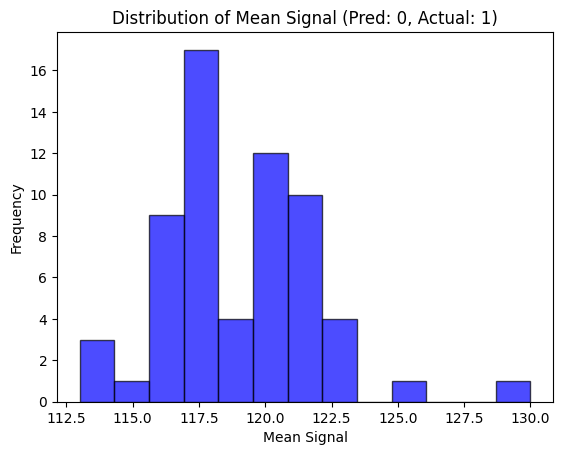

In [ ]:
# Plot the histogram
#plt.hist(data, bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.hist(data, bins=nunique, alpha=0.7, color='blue', edgecolor='black')

# Customize the plot
plt.title('Distribution of Mean Signal (Pred: 0, Actual: 1)')
plt.xlabel('Mean Signal')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [ ]:
FN_merged_df = pd.merge(FN_df, train_df[['transcript_id','transcript_position','reads']], on = ['transcript_id','transcript_position'])

In [ ]:
FN_merged_df['means'] = FN_merged_df['reads'].apply(get_means)
FN_merged_df

,transcript_id,transcript_position,nreads,0,1,actual,pred,correct,wrong,reads,means
0,ENST00000220913,575,2167,0.599616,0.400384,1,0,False,True,"[[0.00863, 4.26, 97.8, 0.00449, 6.84, 119.0, 0...","[119.0, 127.0, 125.0, 119.0, 112.0, 119.0, 115..."
1,ENST00000224073,247,7177,0.887948,0.112052,1,0,False,True,"[[0.00598, 3.46, 94.5, 0.00563, 2.33, 114.0, 0...","[114.0, 120.0, 123.0, 118.0, 110.0, 120.0, 119..."
2,ENST00000228506,1168,1964,0.535495,0.464505,1,0,False,True,"[[0.00465, 2.57, 110.0, 0.0127, 4.16, 99.4, 0....","[99.4, 98.5, 103.0, 99.0, 97.6, 103.0, 104.0, ..."
3,ENST00000241600,726,2722,0.567106,0.432894,1,0,False,True,"[[0.00551, 10.4, 115.0, 0.0083, 10.3, 102.0, 0...","[102.0, 98.5, 93.7, 91.9, 93.8, 95.1, 96.7, 97..."
4,ENST00000242784,628,5583,0.750471,0.249529,1,0,False,True,"[[0.00645, 2.15, 110.0, 0.00232, 2.32, 105.0, ...","[105.0, 105.0, 108.0, 105.0, 101.0, 108.0, 105..."
...,...,...,...,...,...,...,...,...,...,...,...
143,ENST00000581693,1591,1509,0.574110,0.425890,1,0,False,True,"[[0.00498, 2.28, 105.0, 0.00538, 4.01, 101.0, ...","[101.0, 104.0, 108.0, 102.0, 102.0, 102.0, 101..."
144,ENST00000588734,1172,1699,0.528458,0.471542,1,0,False,True,"[[0.0169, 7.54, 124.0, 0.0176, 3.75, 103.0, 0....","[103.0, 102.0, 102.0, 103.0, 100.0, 102.0, 103..."
145,ENST00000602540,1160,7222,0.521930,0.478070,1,0,False,True,"[[0.00581, 3.3, 106.0, 0.00531, 3.96, 92.3, 0....","[92.3, 99.1, 94.7, 99.8, 96.5, 99.4, 99.9, 95...."
146,ENST00000605895,861,3146,0.545153,0.454847,1,0,False,True,"[[0.00713, 1.43, 86.3, 0.00631, 2.99, 99.4, 0....","[99.4, 102.0, 97.9, 93.7, 97.0, 98.1, 102.0, 9..."


[119.0, 127.0, 125.0, 119.0, 112.0, 119.0, 115.0, 117.0, 113.0, 113.0, 117.0, 117.0, 122.0, 125.0, 118.0, 113.0, 116.0, 122.0, 120.0, 112.0, 119.0, 117.0, 122.0, 114.0, 122.0, 118.0, 117.0, 116.0, 116.0, 113.0, 113.0, 116.0, 119.0]


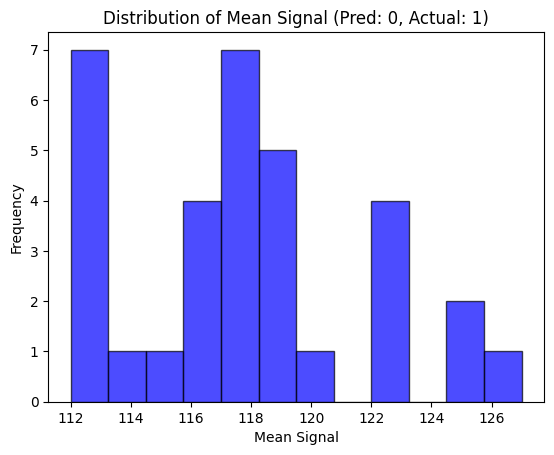

[114.0, 120.0, 123.0, 118.0, 110.0, 120.0, 119.0, 124.0, 121.0, 116.0, 117.0, 117.0, 123.0, 123.0, 118.0, 122.0, 118.0, 121.0, 117.0, 120.0, 117.0, 118.0, 115.0, 117.0, 117.0, 121.0, 116.0, 128.0, 117.0, 118.0, 117.0, 119.0, 120.0, 122.0, 125.0, 124.0, 122.0, 123.0, 118.0, 116.0, 119.0, 121.0, 120.0, 119.0, 122.0, 124.0, 117.0, 117.0, 121.0, 119.0, 113.0, 116.0, 118.0, 118.0, 118.0, 119.0, 122.0, 120.0, 119.0, 123.0, 116.0, 116.0, 120.0, 119.0, 119.0, 117.0, 122.0, 118.0, 120.0, 120.0, 123.0, 118.0, 116.0, 121.0, 120.0, 120.0, 116.0, 118.0, 119.0, 119.0, 122.0, 123.0, 116.0, 117.0, 116.0, 122.0, 117.0, 118.0, 119.0, 111.0, 120.0, 125.0, 118.0, 116.0, 118.0, 119.0, 123.0, 109.0, 124.0, 120.0, 115.0, 111.0, 117.0, 117.0, 120.0, 115.0, 117.0, 119.0, 122.0, 118.0]


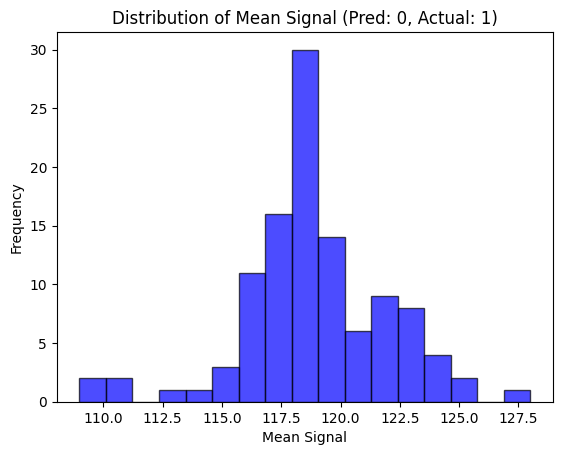

[99.4, 98.5, 103.0, 99.0, 97.6, 103.0, 104.0, 101.0, 97.7, 94.6, 103.0, 99.4, 99.6, 97.0, 101.0, 102.0, 99.0, 100.0, 89.6, 98.6, 100.0, 94.2, 99.0, 102.0, 103.0, 97.8, 89.0, 97.8, 97.4, 100.0]


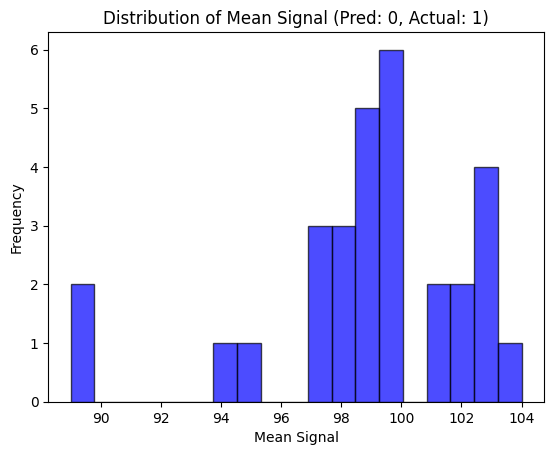

[102.0, 98.5, 93.7, 91.9, 93.8, 95.1, 96.7, 97.2, 94.4, 94.7, 94.1, 96.9, 96.7, 98.0, 97.8, 97.6, 93.9, 94.2, 96.9, 101.0, 95.9, 95.3, 96.8, 96.3, 99.6, 98.5, 96.8, 95.5, 97.7, 85.0, 96.2, 98.3, 94.2, 98.9, 97.6, 88.0, 99.7, 94.8, 98.3, 96.2, 85.1, 92.9]


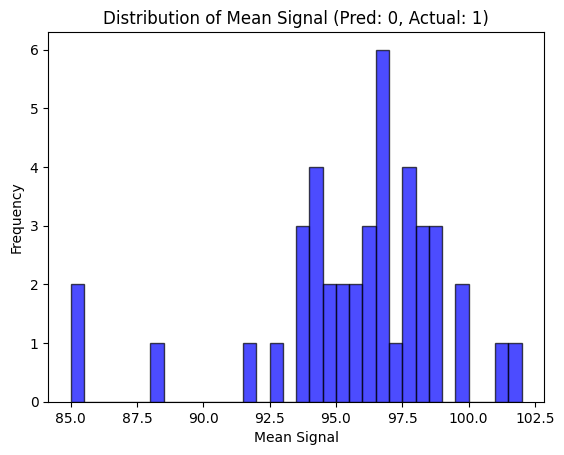

[105.0, 105.0, 108.0, 105.0, 101.0, 108.0, 105.0, 102.0, 104.0, 103.0, 108.0, 108.0, 105.0, 104.0, 107.0, 104.0, 105.0, 105.0, 101.0, 105.0, 104.0, 103.0, 102.0, 98.8, 102.0, 101.0, 106.0, 105.0, 104.0, 104.0, 107.0, 106.0, 108.0, 108.0, 108.0, 103.0, 99.0, 102.0, 103.0, 103.0, 101.0, 103.0, 109.0, 104.0, 104.0, 107.0, 104.0, 107.0, 99.9, 101.0, 105.0, 101.0, 102.0, 106.0, 100.0, 106.0, 97.0, 110.0, 109.0, 105.0, 109.0, 103.0, 112.0, 102.0, 104.0, 106.0, 101.0, 106.0, 105.0, 109.0, 104.0, 106.0, 103.0, 98.2, 105.0, 106.0, 106.0, 102.0, 102.0, 103.0, 104.0, 106.0, 104.0, 105.0, 104.0]


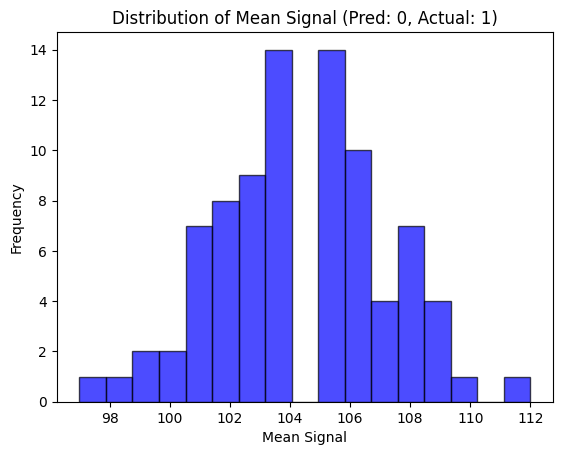

In [ ]:
for i in range(5):
  data = FN_merged_df.iloc[i]['means']
  print(data)
  nunique = len(set(data))
  # Plot the histogram
  #plt.hist(data, bins='auto', alpha=0.7, color='blue', edgecolor='black')
  plt.hist(data, bins=nunique, alpha=0.7, color='blue', edgecolor='black')

  # Customize the plot
  plt.title('Distribution of Mean Signal (Pred: 0, Actual: 1)')
  plt.xlabel('Mean Signal')
  plt.ylabel('Frequency')

  # Show the plot
  plt.show()

#### False positives

In [ ]:
#finding the distribution of an incorrectly predicted transcript id & pos
pred_wrong = nread_df[nread_df['correct']==False]
# Predicted modification when there isn't
FP_df = pred_wrong[pred_wrong['actual']==0]
FP_df

,transcript_id,transcript_position,nreads,0,1,actual,pred,correct,wrong
8,ENST00000000233,471,13572,0.372473,0.627527,0,1,False,True
12,ENST00000000233,665,13474,0.276995,0.723005,0,1,False,True
16,ENST00000000233,765,13196,0.262331,0.737669,0,1,False,True
46,ENST00000000412,1960,4190,0.497446,0.502554,0,1,False,True
57,ENST00000000412,2580,4078,0.022197,0.977803,0,1,False,True
...,...,...,...,...,...,...,...,...,...
121759,ENST00000641390,2060,3723,0.353987,0.646013,0,1,False,True
121762,ENST00000641390,2198,3806,0.286174,0.713826,0,1,False,True
121780,ENST00000641708,1090,1380,0.191731,0.808269,0,1,False,True
121795,ENST00000641784,2270,3594,0.418493,0.581507,0,1,False,True


In [ ]:
import json
def get_means(input_reads):
    input_reads = json.loads(input_reads)
    #for var in range(9): #each var each position
    val_list = []
    for read in input_reads:
        val_list.append(read[5])
    return val_list

In [ ]:
FP_merged_df = pd.merge(FP_df, train_df[['transcript_id','transcript_position','reads']], on = ['transcript_id','transcript_position'])
FP_merged_df['means'] = FP_merged_df['reads'].apply(get_means)
FP_merged_df

,transcript_id,transcript_position,nreads,0,1,actual,pred,correct,wrong,reads,means
0,ENST00000000233,471,13572,0.372473,0.627527,0,1,False,True,"[[0.00266, 10.6, 125.0, 0.00681, 2.87, 104.0, ...","[104.0, 105.0, 102.0, 102.0, 102.0, 104.0, 101..."
1,ENST00000000233,665,13474,0.276995,0.723005,0,1,False,True,"[[0.0098, 2.67, 118.0, 0.0186, 5.3, 123.0, 0.0...","[123.0, 123.0, 123.0, 118.0, 118.0, 126.0, 127..."
2,ENST00000000233,765,13196,0.262331,0.737669,0,1,False,True,"[[0.00303, 2.86, 122.0, 0.00654, 8.68, 119.0, ...","[119.0, 124.0, 109.0, 122.0, 118.0, 123.0, 129..."
3,ENST00000000412,1960,4190,0.497446,0.502554,0,1,False,True,"[[0.00232, 1.66, 106.0, 0.00606, 3.74, 114.0, ...","[114.0, 123.0, 128.0, 119.0, 124.0, 125.0, 128..."
4,ENST00000000412,2580,4078,0.022197,0.977803,0,1,False,True,"[[0.00858, 2.97, 120.0, 0.00232, 3.31, 120.0, ...","[120.0, 120.0, 123.0, 117.0, 117.0, 121.0, 118..."
...,...,...,...,...,...,...,...,...,...,...,...
10257,ENST00000641390,2060,3723,0.353987,0.646013,0,1,False,True,"[[0.00465, 7.7, 123.0, 0.00531, 3.34, 103.0, 0...","[103.0, 105.0, 98.4, 101.0, 102.0, 101.0, 103...."
10258,ENST00000641390,2198,3806,0.286174,0.713826,0,1,False,True,"[[0.00826, 11.1, 119.0, 0.0156, 4.22, 93.1, 0....","[93.1, 103.0, 103.0, 100.0, 101.0, 103.0, 99.8..."
10259,ENST00000641708,1090,1380,0.191731,0.808269,0,1,False,True,"[[0.00332, 6.6, 128.0, 0.00166, 8.84, 110.0, 0...","[110.0, 99.2, 99.2, 105.0, 96.9, 97.1, 103.0, ..."
10260,ENST00000641784,2270,3594,0.418493,0.581507,0,1,False,True,"[[0.00764, 2.24, 121.0, 0.0146, 5.41, 122.0, 0...","[122.0, 127.0, 120.0, 118.0, 110.0, 130.0, 121..."


[104.0, 105.0, 102.0, 102.0, 102.0, 104.0, 101.0, 100.0, 104.0, 103.0, 102.0, 98.2, 98.4, 108.0, 102.0, 100.0, 102.0, 97.6, 101.0, 101.0, 101.0, 99.1, 102.0, 103.0, 102.0, 103.0, 99.6, 102.0, 103.0, 98.8, 103.0, 99.7, 102.0, 99.3, 104.0, 104.0, 104.0, 102.0, 94.7, 102.0, 101.0, 96.2, 96.9, 103.0, 102.0, 102.0, 102.0, 101.0, 98.7, 103.0, 104.0, 102.0, 101.0, 99.8, 101.0, 101.0, 97.5, 101.0, 103.0, 102.0, 101.0, 102.0, 104.0, 100.0, 104.0, 101.0, 99.2, 99.9, 102.0, 102.0, 103.0, 103.0, 102.0, 101.0, 103.0, 104.0, 102.0, 97.9, 102.0, 101.0, 103.0, 105.0, 99.1, 104.0, 100.0, 104.0, 104.0, 101.0, 105.0, 102.0, 101.0, 98.2, 99.3, 101.0, 102.0, 104.0, 101.0, 104.0, 99.9, 101.0, 103.0, 99.4, 105.0, 100.0, 102.0, 103.0, 98.7, 101.0, 104.0, 104.0, 105.0, 101.0, 102.0, 102.0, 99.0, 103.0, 103.0, 102.0, 104.0, 100.0, 102.0, 102.0, 98.7, 102.0, 101.0, 101.0, 103.0, 104.0, 100.0, 97.1, 104.0, 100.0, 101.0, 104.0, 99.8, 102.0, 95.9, 102.0, 103.0, 101.0, 104.0, 101.0, 104.0, 104.0, 101.0, 105.0, 105.0

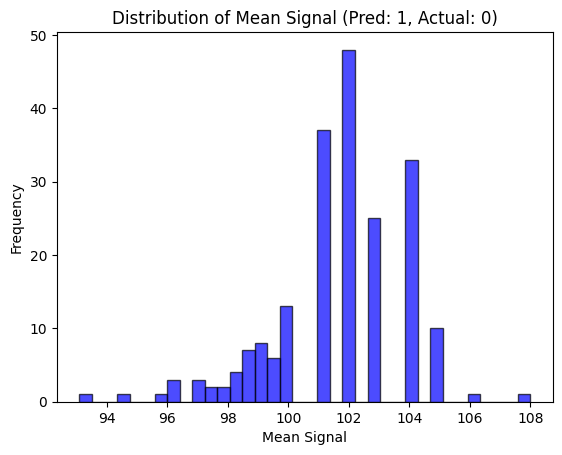

[123.0, 123.0, 123.0, 118.0, 118.0, 126.0, 127.0, 119.0, 127.0, 126.0, 123.0, 122.0, 128.0, 125.0, 116.0, 124.0, 126.0, 124.0, 127.0, 127.0, 126.0, 124.0, 130.0, 124.0, 126.0, 127.0, 124.0, 121.0, 120.0, 127.0, 124.0, 128.0, 123.0, 125.0, 125.0, 125.0, 124.0, 124.0, 127.0, 126.0, 124.0, 124.0, 125.0, 128.0, 123.0, 123.0, 126.0, 129.0, 122.0, 125.0, 126.0, 122.0, 126.0, 126.0, 125.0, 125.0, 123.0, 126.0, 126.0, 131.0, 124.0, 125.0, 126.0, 125.0, 124.0, 124.0, 123.0, 128.0, 128.0, 129.0, 128.0, 122.0, 124.0, 123.0, 114.0, 126.0, 126.0, 123.0, 123.0, 126.0, 126.0, 125.0, 121.0, 124.0, 128.0, 124.0, 125.0, 125.0, 125.0, 125.0, 127.0, 124.0, 125.0, 125.0, 125.0, 129.0, 124.0, 126.0, 124.0, 125.0, 127.0, 130.0, 122.0, 130.0, 125.0, 125.0, 126.0, 126.0, 130.0, 124.0, 126.0, 124.0, 131.0, 126.0, 125.0, 126.0, 128.0, 125.0, 124.0, 124.0, 125.0, 126.0, 132.0, 123.0, 121.0, 124.0, 125.0, 128.0, 125.0, 124.0, 124.0, 124.0, 125.0, 126.0, 124.0, 126.0, 121.0, 126.0, 128.0, 126.0, 125.0, 125.0, 128.0

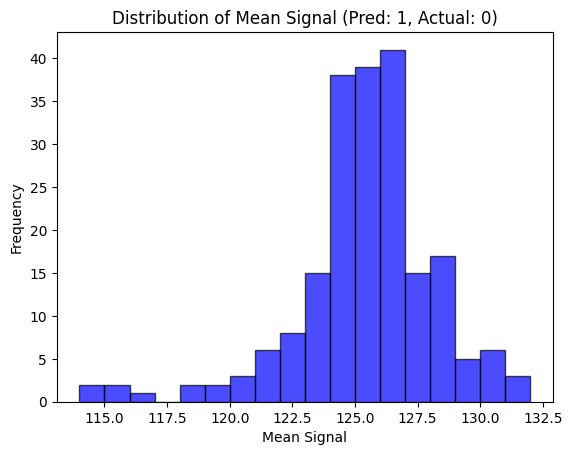

[119.0, 124.0, 109.0, 122.0, 118.0, 123.0, 129.0, 124.0, 123.0, 131.0, 127.0, 123.0, 125.0, 126.0, 125.0, 115.0, 120.0, 118.0, 124.0, 124.0, 124.0, 126.0, 126.0, 118.0, 114.0, 107.0, 128.0, 115.0, 123.0, 126.0, 120.0, 126.0, 125.0, 124.0, 124.0, 116.0, 126.0, 125.0, 125.0, 123.0, 111.0, 127.0, 121.0, 113.0, 126.0, 115.0, 124.0, 126.0, 119.0, 121.0, 124.0, 126.0, 125.0, 124.0, 121.0, 115.0, 123.0, 122.0, 126.0, 127.0, 124.0, 118.0, 122.0, 124.0, 113.0, 125.0, 120.0, 121.0, 119.0, 124.0, 122.0, 117.0, 126.0, 123.0, 124.0, 127.0, 119.0, 125.0, 122.0, 120.0, 123.0, 122.0, 116.0, 124.0, 125.0, 122.0, 129.0, 121.0, 123.0, 117.0, 118.0, 120.0, 127.0, 126.0, 116.0, 122.0, 126.0, 123.0, 127.0, 117.0, 118.0, 114.0, 119.0, 115.0, 122.0, 127.0, 126.0, 119.0, 123.0, 127.0, 121.0, 127.0, 117.0, 117.0, 122.0, 126.0, 125.0, 119.0, 126.0, 124.0, 122.0, 119.0, 119.0, 122.0, 129.0, 121.0, 121.0, 118.0, 118.0, 119.0, 123.0, 124.0, 128.0, 124.0, 123.0, 125.0, 124.0, 125.0, 122.0, 122.0, 118.0, 124.0, 118.0

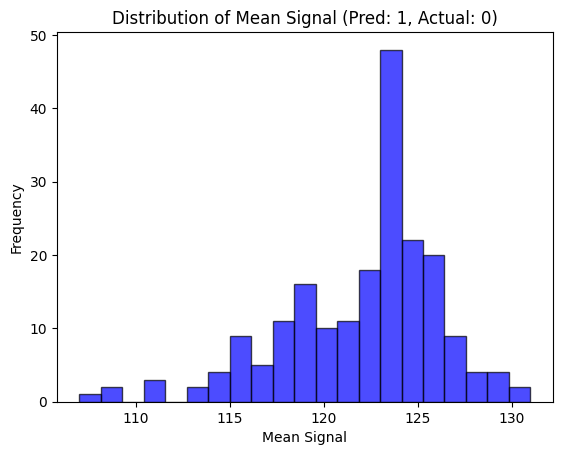

[114.0, 123.0, 128.0, 119.0, 124.0, 125.0, 128.0, 125.0, 129.0, 128.0, 127.0, 122.0, 123.0, 121.0, 126.0, 125.0, 128.0, 126.0, 124.0, 129.0, 128.0, 127.0, 126.0, 122.0, 120.0, 115.0, 123.0, 125.0, 124.0, 128.0, 116.0, 128.0, 115.0, 134.0, 129.0, 128.0, 124.0, 124.0, 126.0, 125.0, 127.0, 118.0, 121.0, 127.0, 123.0, 122.0, 122.0, 125.0, 129.0, 134.0, 124.0, 126.0, 131.0, 122.0, 125.0, 120.0, 128.0, 123.0, 130.0, 118.0, 126.0, 126.0, 118.0, 130.0]


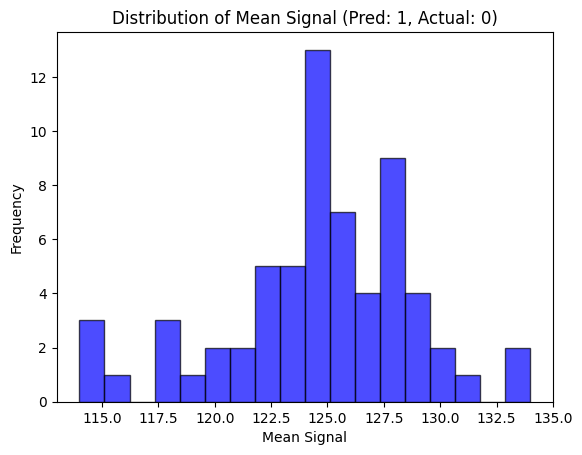

[120.0, 120.0, 123.0, 117.0, 117.0, 121.0, 118.0, 114.0, 120.0, 119.0, 119.0, 116.0, 115.0, 116.0, 122.0, 117.0, 118.0, 123.0, 120.0, 120.0, 121.0, 120.0, 116.0, 121.0, 113.0, 120.0, 121.0, 119.0, 117.0, 118.0, 116.0, 120.0, 116.0, 123.0, 120.0, 117.0, 121.0, 118.0, 120.0, 119.0, 130.0, 118.0, 118.0, 116.0, 122.0, 121.0, 114.0, 118.0, 118.0, 125.0, 121.0, 116.0, 116.0, 120.0, 118.0, 117.0, 117.0, 120.0, 116.0, 123.0, 117.0, 121.0]


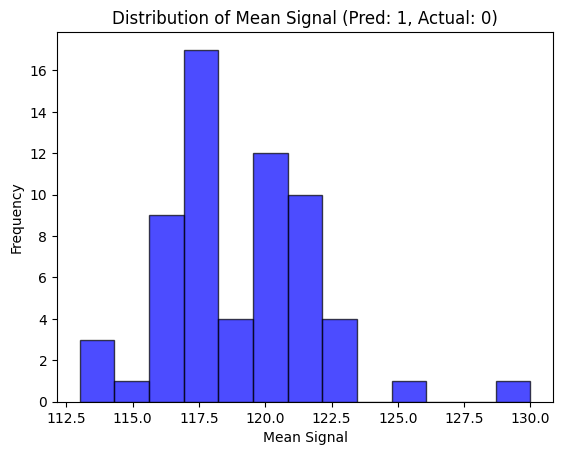

In [ ]:
for i in range(5):
  data = FP_merged_df.iloc[i]['means']
  print(data)
  nunique = len(set(data))
  # Plot the histogram
  #plt.hist(data, bins='auto', alpha=0.7, color='blue', edgecolor='black')
  plt.hist(data, bins=nunique, alpha=0.7, color='blue', edgecolor='black')

  # Customize the plot
  plt.title('Distribution of Mean Signal (Pred: 1, Actual: 0)')
  plt.xlabel('Mean Signal')
  plt.ylabel('Frequency')
  # Show the plot
  plt.show()

#### True positives

In [ ]:
# Finding the distribution of an correctly predicted transcript id & pos
# Predicted modification correctly
TP_df = nread_df[(nread_df['correct']==True) & (nread_df['actual']==1)]
TP_df

,transcript_id,transcript_position,nreads,0,1,actual,pred,correct,wrong
17,ENST00000000233,913,11772,0.070903,0.929097,1,1,True,False
52,ENST00000000412,2440,3934,0.019535,0.980465,1,1,True,False
53,ENST00000000412,2462,3716,0.384673,0.615327,1,1,True,False
55,ENST00000000412,2499,2871,0.112767,0.887233,1,1,True,False
229,ENST00000007390,1096,3147,0.011266,0.988734,1,1,True,False
...,...,...,...,...,...,...,...,...,...
121828,ENST00000641834,1093,4791,0.046672,0.953328,1,1,True,False
121831,ENST00000641834,1255,4564,0.011462,0.988538,1,1,True,False
121832,ENST00000641834,1259,2627,0.286261,0.713739,1,1,True,False
121833,ENST00000641834,1348,4784,0.010081,0.989919,1,1,True,False


In [ ]:
import json
def get_means(input_reads):
    input_reads = json.loads(input_reads)
    #for var in range(9): #each var each position
    val_list = []
    for read in input_reads:
        val_list.append(read[5])
    return val_list

In [ ]:
TP_merged_df = pd.merge(TP_df, train_df[['transcript_id','transcript_position','reads']], on = ['transcript_id','transcript_position'])
TP_merged_df['means'] = TP_merged_df['reads'].apply(get_means)
TP_merged_df

,transcript_id,transcript_position,nreads,0,1,actual,pred,correct,wrong,reads,means
0,ENST00000000233,913,11772,0.070903,0.929097,1,1,True,False,"[[0.00478, 2.67, 120.0, 0.019, 3.4, 124.0, 0.0...","[124.0, 123.0, 113.0, 115.0, 122.0, 123.0, 123..."
1,ENST00000000412,2440,3934,0.019535,0.980465,1,1,True,False,"[[0.00531, 4.27, 119.0, 0.00764, 9.57, 114.0, ...","[114.0, 119.0, 118.0, 116.0, 121.0, 118.0, 113..."
2,ENST00000000412,2462,3716,0.384673,0.615327,1,1,True,False,"[[0.00777, 6.39, 123.0, 0.0154, 2.67, 96.8, 0....","[96.8, 94.3, 97.2, 96.2, 96.0, 94.8, 93.6, 94...."
3,ENST00000000412,2499,2871,0.112767,0.887233,1,1,True,False,"[[0.00736, 3.78, 119.0, 0.00564, 15.3, 107.0, ...","[107.0, 116.0, 115.0, 108.0, 121.0, 118.0, 107..."
4,ENST00000007390,1096,3147,0.011266,0.988734,1,1,True,False,"[[0.0083, 7.71, 120.0, 0.0244, 2.5, 121.0, 0.0...","[121.0, 122.0, 126.0, 122.0, 120.0, 122.0, 118..."
...,...,...,...,...,...,...,...,...,...,...,...
5322,ENST00000641834,1093,4791,0.046672,0.953328,1,1,True,False,"[[0.00952, 5.21, 120.0, 0.00564, 3.96, 120.0, ...","[120.0, 120.0, 119.0, 121.0, 121.0, 120.0, 122..."
5323,ENST00000641834,1255,4564,0.011462,0.988538,1,1,True,False,"[[0.0128, 5.73, 115.0, 0.00697, 5.08, 117.0, 0...","[117.0, 114.0, 119.0, 110.0, 121.0, 117.0, 120..."
5324,ENST00000641834,1259,2627,0.286261,0.713739,1,1,True,False,"[[0.00498, 2.94, 125.0, 0.0119, 6.96, 124.0, 0...","[124.0, 128.0, 124.0, 132.0, 127.0, 124.0, 126..."
5325,ENST00000641834,1348,4784,0.010081,0.989919,1,1,True,False,"[[0.0112, 2.96, 116.0, 0.0093, 3.24, 115.0, 0....","[115.0, 124.0, 102.0, 115.0, 118.0, 115.0, 118..."


[124.0, 123.0, 113.0, 115.0, 122.0, 123.0, 123.0, 126.0, 120.0, 120.0, 120.0, 112.0, 121.0, 126.0, 111.0, 118.0, 114.0, 124.0, 124.0, 118.0, 125.0, 122.0, 120.0, 122.0, 115.0, 111.0, 122.0, 121.0, 119.0, 123.0, 119.0, 123.0, 119.0, 119.0, 125.0, 120.0, 126.0, 115.0, 112.0, 120.0, 108.0, 126.0, 119.0, 119.0, 119.0, 112.0, 123.0, 118.0, 120.0, 121.0, 118.0, 118.0, 123.0, 116.0, 121.0, 124.0, 116.0, 121.0, 120.0, 114.0, 116.0, 125.0, 124.0, 119.0, 113.0, 121.0, 120.0, 123.0, 125.0, 123.0, 119.0, 122.0, 118.0, 118.0, 122.0, 118.0, 119.0, 117.0, 121.0, 115.0, 118.0, 120.0, 124.0, 119.0, 112.0, 113.0, 111.0, 117.0, 120.0, 119.0, 127.0, 126.0, 124.0, 129.0, 118.0, 119.0, 117.0, 119.0, 120.0, 122.0, 127.0, 118.0, 125.0, 117.0, 126.0, 120.0, 123.0, 121.0, 119.0, 121.0, 125.0, 115.0, 119.0, 111.0, 122.0, 119.0, 121.0, 116.0, 119.0, 117.0, 125.0, 122.0, 113.0, 124.0, 119.0, 117.0, 125.0, 126.0, 117.0, 119.0, 116.0, 116.0, 116.0, 116.0, 116.0, 119.0, 116.0, 114.0, 125.0, 119.0, 120.0, 122.0, 113.0

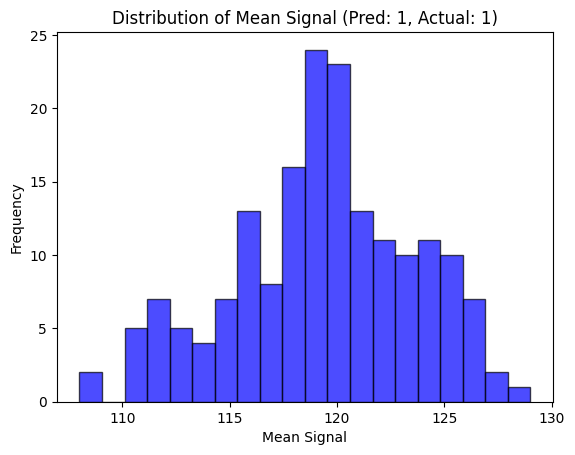

[114.0, 119.0, 118.0, 116.0, 121.0, 118.0, 113.0, 115.0, 108.0, 112.0, 115.0, 118.0, 108.0, 114.0, 122.0, 115.0, 124.0, 117.0, 117.0, 110.0, 118.0, 114.0, 118.0, 120.0, 113.0, 112.0, 120.0, 114.0, 116.0, 112.0, 118.0, 115.0, 112.0, 113.0, 115.0, 118.0, 115.0, 118.0, 111.0, 122.0, 116.0, 121.0, 119.0, 112.0, 124.0, 123.0, 123.0, 111.0, 120.0, 117.0, 110.0, 122.0, 122.0, 113.0, 118.0, 119.0, 114.0, 118.0, 118.0, 116.0]


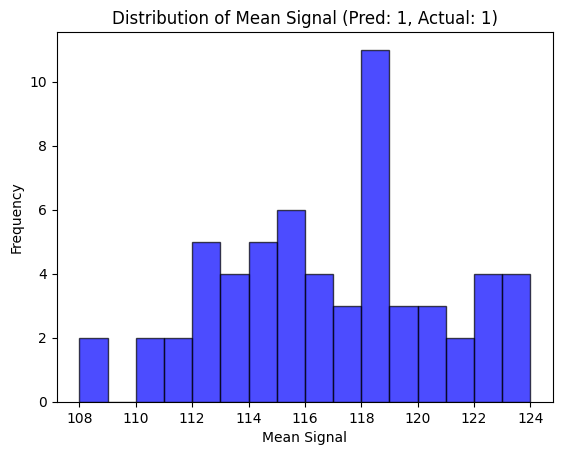

[96.8, 94.3, 97.2, 96.2, 96.0, 94.8, 93.6, 94.8, 93.5, 94.3, 102.0, 93.4, 96.0, 91.5, 97.1, 100.0, 94.4, 96.2, 95.0, 95.8, 94.7, 94.5, 90.9, 95.8, 95.2, 98.3, 96.7, 94.7, 93.8, 95.9, 95.9, 94.3, 104.0, 95.6, 99.5, 94.4, 96.1, 94.4, 94.0, 94.7, 93.2, 91.2, 103.0, 95.2, 89.5, 95.2, 95.0, 98.2, 97.4, 97.6, 98.3, 93.2, 95.1, 96.2, 97.7, 93.8, 96.4]


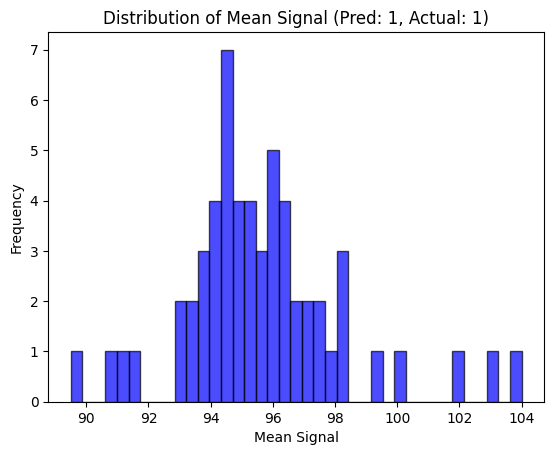

[107.0, 116.0, 115.0, 108.0, 121.0, 118.0, 107.0, 114.0, 112.0, 125.0, 122.0, 115.0, 116.0, 113.0, 115.0, 120.0, 120.0, 114.0, 112.0, 116.0, 117.0, 110.0, 112.0, 110.0, 125.0, 110.0, 113.0, 122.0, 109.0, 118.0, 109.0, 115.0, 118.0, 110.0, 110.0, 120.0, 116.0, 108.0, 116.0, 120.0, 116.0, 115.0, 112.0, 117.0]


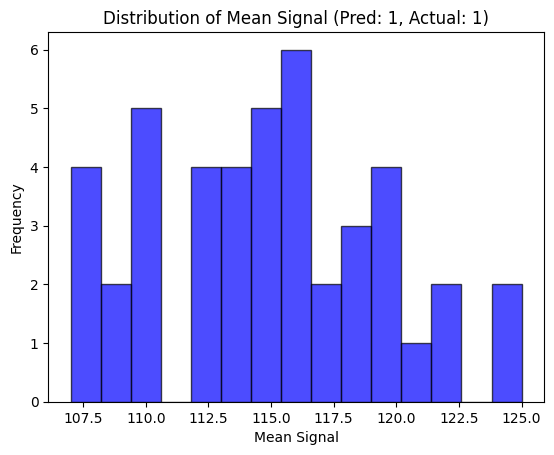

[121.0, 122.0, 126.0, 122.0, 120.0, 122.0, 118.0, 127.0, 113.0, 121.0, 123.0, 126.0, 121.0, 122.0, 123.0, 127.0, 119.0, 123.0, 128.0, 121.0, 127.0, 122.0, 122.0, 113.0, 114.0, 131.0, 121.0, 128.0, 122.0, 120.0, 123.0, 128.0, 126.0, 122.0, 120.0, 119.0, 121.0, 125.0, 119.0, 120.0, 120.0, 120.0, 112.0, 120.0, 130.0, 118.0, 121.0, 121.0]


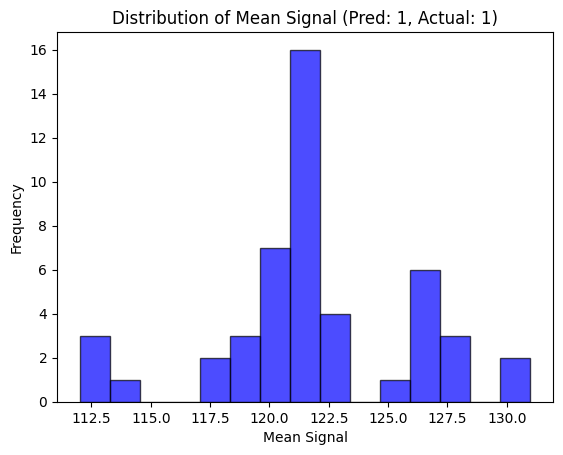

In [ ]:
for i in range(5):
  data = TP_merged_df.iloc[i]['means']
  print(data)
  nunique = len(set(data))
  # Plot the histogram
  #plt.hist(data, bins='auto', alpha=0.7, color='blue', edgecolor='black')
  plt.hist(data, bins=nunique, alpha=0.7, color='blue', edgecolor='black')

  # Customize the plot
  plt.title('Distribution of Mean Signal (Pred: 1, Actual: 1)')
  plt.xlabel('Mean Signal')
  plt.ylabel('Frequency')
  # Show the plot
  plt.show()

#### True negatives

In [ ]:
# Finding the distribution of an correctly predicted transcript id & pos
# Predicted modification correctly
TN_df = nread_df[(nread_df['correct']==True) & (nread_df['actual']==0)]
TN_df

,transcript_id,transcript_position,nreads,0,1,actual,pred,correct,wrong
0,ENST00000000233,244,12101,0.995552,0.004448,0,0,True,False
1,ENST00000000233,261,11322,0.830490,0.169510,0,0,True,False
2,ENST00000000233,316,12075,0.979434,0.020566,0,0,True,False
3,ENST00000000233,332,12942,0.722672,0.277328,0,0,True,False
4,ENST00000000233,368,12872,0.999200,0.000800,0,0,True,False
...,...,...,...,...,...,...,...,...,...
121829,ENST00000641834,1193,4512,0.906367,0.093633,0,0,True,False
121830,ENST00000641834,1234,4930,0.954850,0.045150,0,0,True,False
121834,ENST00000641834,1429,4535,0.986273,0.013727,0,0,True,False
121836,ENST00000641834,1537,3756,0.985963,0.014037,0,0,True,False


In [ ]:
import json
def get_means(input_reads):
    input_reads = json.loads(input_reads)
    #for var in range(9): #each var each position
    val_list = []
    for read in input_reads:
        val_list.append(read[5])
    return val_list

In [ ]:
TN_merged_df = pd.merge(TN_df, train_df[['transcript_id','transcript_position','reads']], on = ['transcript_id','transcript_position'])
TN_merged_df['means'] = TN_merged_df['reads'].apply(get_means)
TN_merged_df

,transcript_id,transcript_position,nreads,0,1,actual,pred,correct,wrong,reads,means
0,ENST00000000233,244,12101,0.995552,0.004448,0,0,True,False,"[[0.00299, 2.06, 125.0, 0.0177, 10.4, 122.0, 0...","[122.0, 126.0, 124.0, 130.0, 129.0, 126.0, 129..."
1,ENST00000000233,261,11322,0.830490,0.169510,0,0,True,False,"[[0.0126, 1.95, 111.0, 0.0125, 1.27, 108.0, 0....","[108.0, 106.0, 108.0, 111.0, 108.0, 100.0, 109..."
2,ENST00000000233,316,12075,0.979434,0.020566,0,0,True,False,"[[0.00432, 2.02, 104.0, 0.00299, 3.56, 99.3, 0...","[99.3, 100.0, 103.0, 100.0, 101.0, 98.6, 99.6,..."
3,ENST00000000233,332,12942,0.722672,0.277328,0,0,True,False,"[[0.0134, 4.71, 132.0, 0.00447, 4.24, 98.8, 0....","[98.8, 97.5, 97.3, 99.3, 102.0, 98.1, 96.0, 97..."
4,ENST00000000233,368,12872,0.999200,0.000800,0,0,True,False,"[[0.015, 6.97, 118.0, 0.0106, 3.04, 123.0, 0.0...","[123.0, 124.0, 124.0, 124.0, 126.0, 123.0, 123..."
...,...,...,...,...,...,...,...,...,...,...,...
106096,ENST00000641834,1193,4512,0.906367,0.093633,0,0,True,False,"[[0.00564, 4.02, 100.0, 0.00631, 9.78, 117.0, ...","[117.0, 122.0, 118.0, 119.0, 123.0, 120.0, 113..."
106097,ENST00000641834,1234,4930,0.954850,0.045150,0,0,True,False,"[[0.00365, 4.22, 127.0, 0.00283, 4.9, 128.0, 0...","[128.0, 130.0, 129.0, 128.0, 130.0, 127.0, 131..."
106098,ENST00000641834,1429,4535,0.986273,0.013727,0,0,True,False,"[[0.00697, 4.25, 112.0, 0.00481, 8.67, 119.0, ...","[119.0, 121.0, 113.0, 112.0, 117.0, 117.0, 116..."
106099,ENST00000641834,1537,3756,0.985963,0.014037,0,0,True,False,"[[0.00396, 3.14, 108.0, 0.00747, 5.79, 125.0, ...","[125.0, 130.0, 130.0, 123.0, 124.0, 121.0, 122..."


[122.0, 126.0, 124.0, 130.0, 129.0, 126.0, 129.0, 131.0, 124.0, 128.0, 122.0, 124.0, 129.0, 129.0, 126.0, 123.0, 126.0, 123.0, 127.0, 127.0, 127.0, 127.0, 127.0, 125.0, 127.0, 128.0, 124.0, 128.0, 127.0, 128.0, 126.0, 124.0, 123.0, 124.0, 126.0, 127.0, 126.0, 126.0, 125.0, 123.0, 126.0, 133.0, 111.0, 127.0, 120.0, 125.0, 128.0, 127.0, 125.0, 126.0, 126.0, 127.0, 131.0, 124.0, 126.0, 128.0, 128.0, 130.0, 130.0, 125.0, 123.0, 126.0, 127.0, 123.0, 125.0, 121.0, 126.0, 122.0, 126.0, 124.0, 125.0, 130.0, 129.0, 126.0, 126.0, 125.0, 128.0, 125.0, 128.0, 125.0, 123.0, 124.0, 127.0, 126.0, 123.0, 125.0, 122.0, 125.0, 124.0, 123.0, 126.0, 124.0, 127.0, 127.0, 126.0, 127.0, 123.0, 127.0, 124.0, 117.0, 127.0, 127.0, 125.0, 126.0, 129.0, 127.0, 126.0, 126.0, 127.0, 115.0, 123.0, 124.0, 127.0, 129.0, 125.0, 128.0, 125.0, 126.0, 126.0, 128.0, 126.0, 128.0, 128.0, 130.0, 128.0, 132.0, 126.0, 123.0, 130.0, 126.0, 126.0, 130.0, 128.0, 126.0, 124.0, 130.0, 126.0, 126.0, 125.0, 119.0, 127.0, 128.0, 129.0

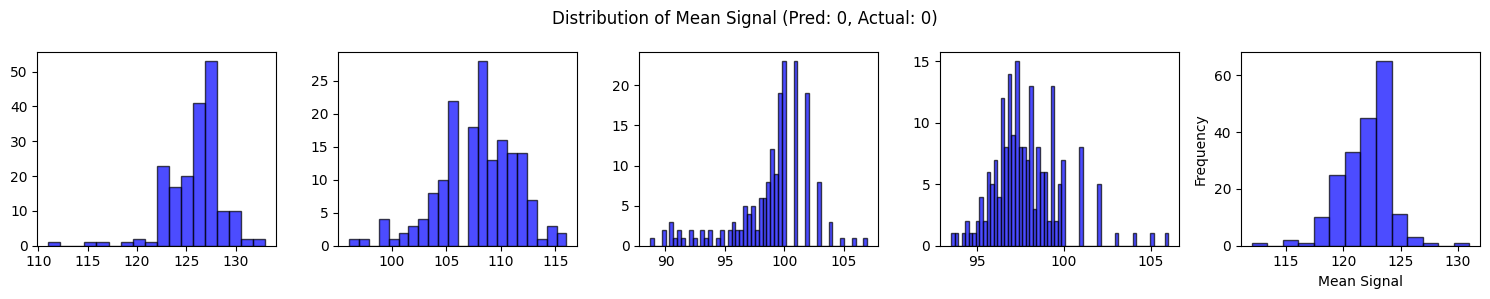

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
  data = TN_merged_df.iloc[i]['means']
  print(data)
  nunique = len(set(data))
  # Plot the histogram
  #plt.hist(data, bins='auto', alpha=0.7, color='blue', edgecolor='black')
  axs[i].hist(data, bins=nunique, alpha=0.7, color='blue', edgecolor='black')
  #axs[i].set_title('Distribution of Mean Signal (Pred: 0, Actual: 0)')
  plt.xlabel('Mean Signal')
  plt.ylabel('Frequency')

fig.suptitle('Distribution of Mean Signal (Pred: 0, Actual: 0)')
plt.tight_layout()
plt.show()

#### Standardised scales

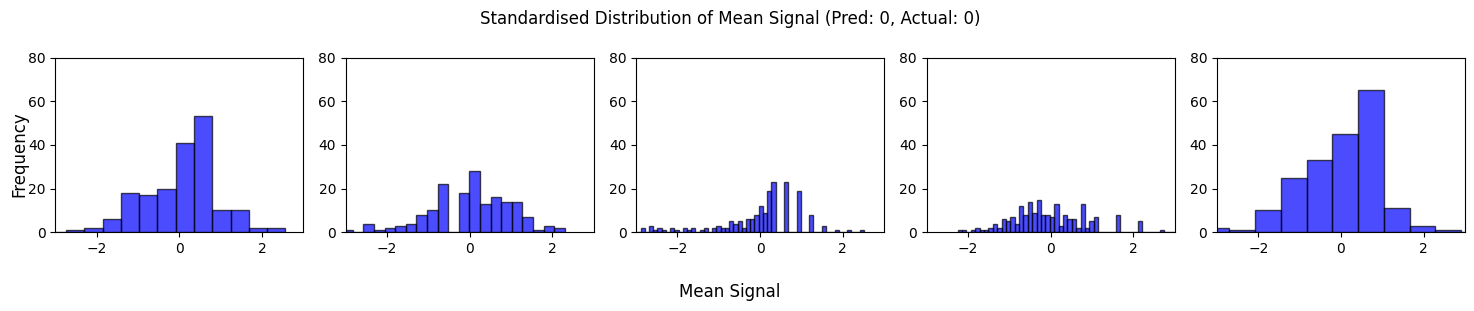

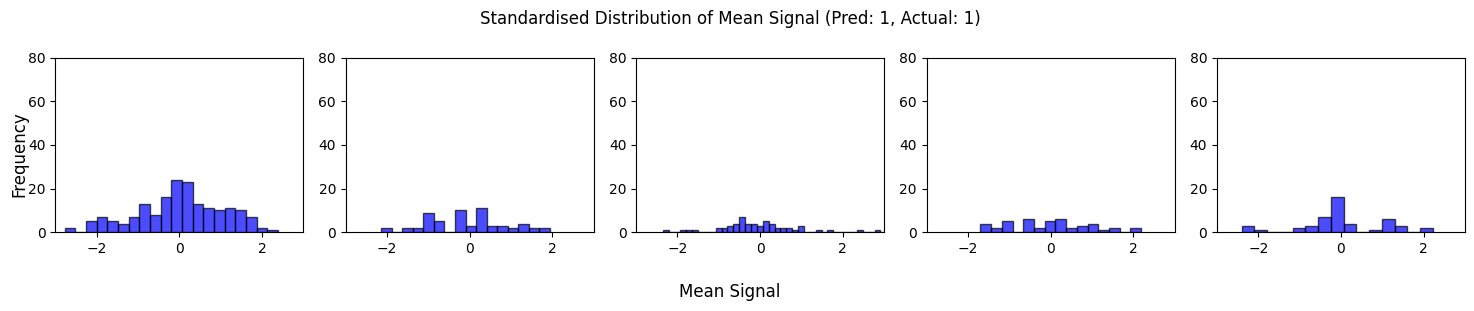

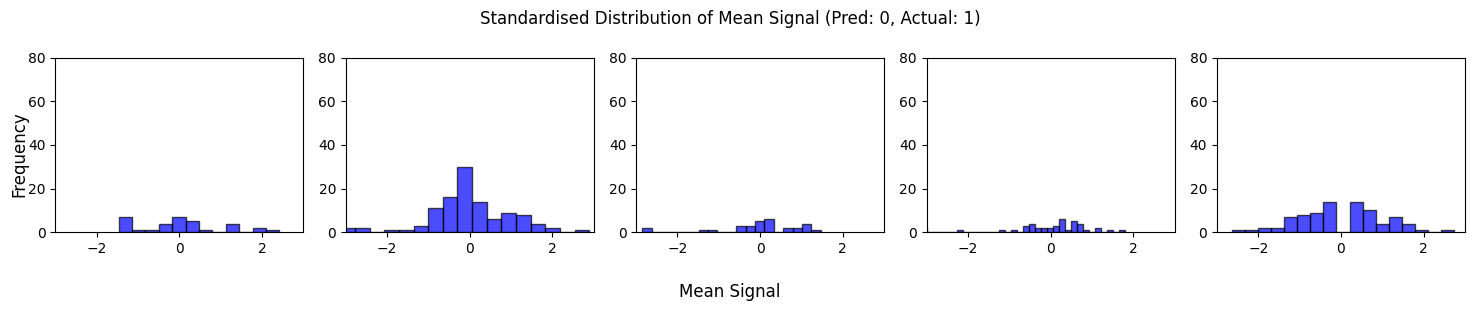

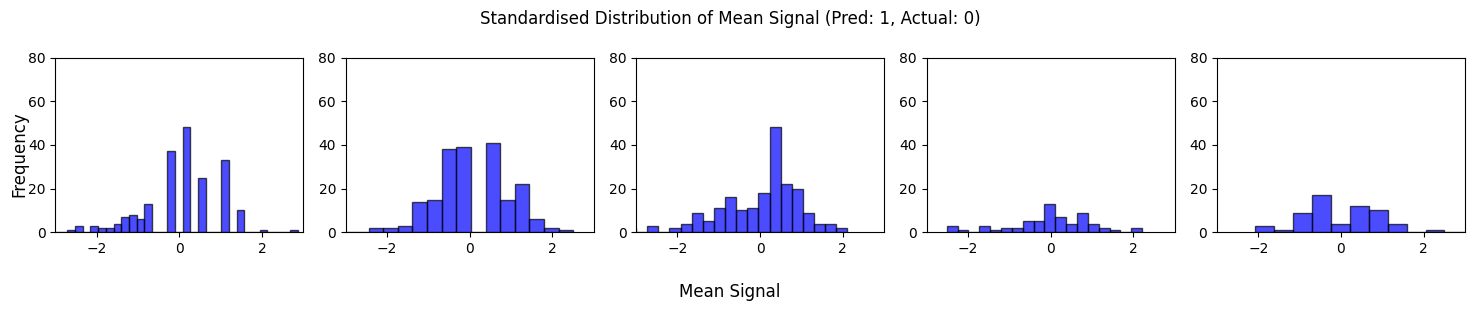

In [ ]:
dfs = [TN_merged_df,TP_merged_df,FN_merged_df,FP_merged_df]
prd = [0,1,0,1]
act = [0,1,1,0]
k=0
for df in dfs:
  fig, axs = plt.subplots(1, 5, figsize=(15, 3))

  for i in range(5):
    data = df.iloc[i]['means']
    # Standardize the data (calculate z-scores)
    data_standardized = (data - np.mean(data)) / np.std(data)
    #print(data)
    nunique = len(set(data))
    # Plot the histogram
    axs[i].hist(data_standardized, bins=nunique, alpha=0.7, color='blue', edgecolor='black')
    #axs[i].set_title('Distribution of Mean Signal (Pred: 0, Actual: 0)')
    # Fix the x-axis and y-axis scale
    axs[i].set_xlim(-3, 3)  # Set x-axis limits
    axs[i].set_ylim(0, 80)   # Set y-axis limits

  fig.supxlabel('Mean Signal')
  fig.supylabel('Frequency')
  fig.suptitle(f'Standardised Distribution of Mean Signal (Pred: {prd[k]}, Actual: {act[k]})')
  plt.tight_layout()
  plt.show()
  k+=1
